In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [21]:
!pip install tensorflow

In [22]:
import tensorflow as tf

In [23]:
!pip install keras

In [24]:
!pip install scikeras

In [25]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [27]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [28]:
!pip install shap
import shap

In [29]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [30]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [31]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [32]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [33]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [34]:
project_id = PROJECT_ID# Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [35]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [36]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [37]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 250),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 250)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [38]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [39]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  250
Number of bots:  250


In [40]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [41]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [42]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  250
Number of human users:  250


## Data preparation

In [43]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [44]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [45]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [46]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [47]:
column_to_remove

['withheld', 'has_profile_image_url']

In [48]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [49]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [50]:
users_df

id  label         username  \
0    1428769922507751429      1  BotoxAesthetics   
1    1484544053572419585      0  blessing_xettry   
2     842202106324951040      1     Mark11474609   
3    1447956502443069446      0      menametaken   
4               21309002      1          Sjouzan   
..                   ...    ...              ...   
495            245953248      0        CurleyOwl   
496           2501572304      1   vinothkumaar87   
497            112438596      0   BoltBurdonKemp   
498  1176030967905103872      1  NyakotyoOnesmus   
499             75364211      0    SenPatRoberts   

                               name    created_at  verified  protected  \
0    dermalfillers Aesthetics botox  1.629480e+09         0          0   
1                  #Blessing xettry  1.642778e+09         0          0   
2                              Mark  1.489632e+09         0          0   
3                         winwinnie  1.634055e+09         0          0   
4                            Zuzana  1.235058e+09         0          0   
..                              ...           ...       ...        ...   
495                            Anna  1.296592e+09         0          0   
496                            Vino  1.400333e+09         0          0   
497                Bolt Burdon Kemp  1.265638e+09         0          0   
498                onesmus nyakotyo  1.569223e+09         0          0   
499             Senator Pat Roberts  1.253302e+09         1          0   

     has_location                    location  has_pinned_tweet  \
0               1     London , United Kingdom                 0   
1               1                       Nepal                 0   
2               1      Kelvin Grove, Brisbane                 0   
3               1                  your walls                 0   
4               1                Brighton, UK                 0   
..            ...                         ...               ...   
495             1                         USA                 1   
496             1                San Jose, CA                 0   
497             1           Islington, London                 1   
498             1  Cambridge UK and Dubai UAE                 0   
499             1                 Kansas, USA                 0   

                         url  followers_count  following_count  tweet_count  \
0    https://t.co/CBDBvXnRKv              2.0             41.0          1.0   
1                                         0.0             24.0          1.0   
2                                         3.0             22.0          4.0   
3                                         0.0             20.0          1.0   
4                                         3.0             42.0          2.0   
..                       ...              ...              ...          ...   
495                                    1142.0            884.0      50949.0   
496                                      13.0            155.0          8.0   
497   http://t.co/OdDp2u4jny           2422.0           1048.0       5527.0   
498                                      15.0            579.0          5.0   
499                                   85366.0            921.0       7216.0   

     listed_count  has_description  \
0             0.0                1   
1             0.0                1   
2             0.0                0   
3             0.0                1   
4             0.0                0   
..            ...              ...   
495          40.0                1   
496           3.0                0   
497          52.0                1   
498           1.0                1   
499        1902.0                1   

                                                                                                                                                          description  \
0    Enhance fillers is a progressive company found in the city of Webminster,We offer a wide range of aesthetic services includ

#### Null and NaN statistics

In [51]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 106
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [52]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [53]:
from datetime import datetime

In [54]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [55]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [56]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0    1428769922507751429      1         0          0             1   
1    1484544053572419585      0         0          0             1   
2     842202106324951040      1         0          0             1   
3    1447956502443069446      0         0          0             1   
4               21309002      1         0          0             1   
..                   ...    ...       ...        ...           ...   
495            245953248      0         0          0             1   
496           2501572304      1         0          0             1   
497            112438596      0         0          0             1   
498  1176030967905103872      1         0          0             1   
499             75364211      0         1          0             1   

     has_pinned_tweet  followers_count  following_count  tweet_count  \
0                   0              2.0             41.0          1.0   
1                   0              0.0             24.0          1.0   
2                   0              3.0             22.0          4.0   
3                   0              0.0             20.0          1.0   
4                   0              3.0             42.0          2.0   
..                ...              ...              ...          ...   
495                 1           1142.0            884.0      50949.0   
496                 0             13.0            155.0          8.0   
497                 1           2422.0           1048.0       5527.0   
498                 0             15.0            579.0          5.0   
499                 0          85366.0            921.0       7216.0   

     listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
0             0.0                1                0.0                0.0   
1             0.0                1                0.0                0.0   
2             0.0                0                0.0                0.0   
3             0.0                1                1.0                0.0   
4             0.0                0                0.0                0.0   
..            ...              ...                ...                ...   
495          40.0                1                0.0                0.0   
496           3.0                0                0.0                0.0   
497          52.0                1                0.0                0.0   
498           1.0                1                0.0                0.0   
499        1902.0                1                0.0                0.0   

     descr_no_mentions  descr_no_urls  url_no_urls  descr_len  account_age  
0                  0.0            0.0          1.0      160.0        208.0  
1                  0.0            0.0          0.0       72.0         54.0  
2                  0.0            0.0          0.0        0.0       1826.0  
3                  0.0            0.0          0.0       85.0        155.0  
4                  0.0            0.0          0.0        0.0       4773.0  
..                 ...            ...          ...        ...          ...  
495                0.0            0.0          0.0      116.0       4061.0  
496                0.0            0.0          0.0        0.0       2860.0  
497                0.0            0.0          1.0      160.0       4419.0  
498                0.0            0.0          0.0      130.0        905.0  
499                1.0            0.0          0.0       53.0       4562.0  

[500 rows x 18 columns]

### Data type conversion (to float)

In [57]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [58]:
train_data, val_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [59]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [60]:
train_data.describe()

id       label    verified   protected  has_location  \
count  3.500000e+02  350.000000  350.000000  350.000000    350.000000   
mean   5.415008e+17    0.491429    0.060000    0.002857      0.800000   
std    5.959773e+17    0.500642    0.237827    0.053452      0.400573   
min    7.608920e+05    0.000000    0.000000    0.000000      0.000000   
25%    2.978243e+08    0.000000    0.000000    0.000000      1.000000   
50%    3.900618e+09    0.000000    0.000000    0.000000      1.000000   
75%    1.175945e+18    1.000000    0.000000    0.000000      1.000000   
max    1.487790e+18    1.000000    1.000000    1.000000      1.000000   

       has_pinned_tweet  followers_count  following_count    tweet_count  \
count        350.000000       350.000000       350.000000     350.000000   
mean           0.180000      7750.337143      1830.297143    7750.745714   
std            0.384737     32282.600618      9722.221370   45316.751316   
min            0.000000         0.000000         0.000000       0.000000   
25%            0.000000        21.000000        56.500000      23.250000   
50%            0.000000       212.500000       228.000000     497.500000   
75%            0.000000      1370.750000       945.250000    3418.000000   
max            1.000000    318014.000000    160807.000000  787615.000000   

       listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
count    350.000000       350.000000         350.000000         350.000000   
mean      99.514286         0.794286           0.354286           0.002857   
std      396.057756         0.404801           1.115235           0.053452   
min        0.000000         0.000000           0.000000           0.000000   
25%        0.000000         1.000000           0.000000           0.000000   
50%        3.000000         1.000000           0.000000           0.000000   
75%       31.750000         1.000000           0.000000           0.000000   
max     5818.000000         1.000000           7.000000           1.000000   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count         350.000000     350.000000   350.000000  350.000000   350.000000  
mean            0.268571       0.100000     0.582857   80.525714  2450.748571  
std             0.791709       0.376608     0.493793   58.228413  1579.890535  
min             0.000000       0.000000     0.000000    0.000000    45.000000  
25%             0.000000       0.000000     0.000000   23.250000   905.250000  
50%             0.000000       0.000000     1.000000   85.000000  2351.000000  
75%             0.000000       0.000000     1.000000  136.750000  3960.000000  
max             6.000000       3.000000     1.000000  169.000000  5514.000000

#### Describes training data for bots

In [61]:
train_data.loc[train_data['label']==1].describe()

id  label  verified  protected  has_location  \
count  1.720000e+02  172.0     172.0      172.0    172.000000   
mean   6.554853e+17    1.0       0.0        0.0      0.593023   
std    6.028453e+17    0.0       0.0        0.0      0.492705   
min    1.349642e+07    1.0       0.0        0.0      0.000000   
25%    1.174261e+09    1.0       0.0        0.0      0.000000   
50%    8.417497e+17    1.0       0.0        0.0      1.000000   
75%    1.249753e+18    1.0       0.0        0.0      1.000000   
max    1.487365e+18    1.0       0.0        0.0      1.000000   

       has_pinned_tweet  followers_count  following_count   tweet_count  \
count        172.000000       172.000000       172.000000    172.000000   
mean           0.127907      3793.866279       803.686047   1198.779070   
std            0.334961     27130.203191      3362.822239   2569.642467   
min            0.000000         0.000000         0.000000      0.000000   
25%            0.000000        12.000000        34.000000      7.000000   
50%            0.000000        76.500000       122.000000    127.000000   
75%            0.000000       327.500000       465.250000    964.750000   
max            1.000000    264663.000000     41564.000000  16025.000000   

       listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
count    172.000000       172.000000         172.000000         172.000000   
mean      20.593023         0.656977           0.261628           0.005814   
std       64.629919         0.476105           0.964961           0.076249   
min        0.000000         0.000000           0.000000           0.000000   
25%        0.000000         0.000000           0.000000           0.000000   
50%        1.000000         1.000000           0.000000           0.000000   
75%        6.000000         1.000000           0.000000           0.000000   
max      507.000000         1.000000           7.000000           1.000000   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count         172.000000     172.000000   172.000000  172.000000   172.000000  
mean            0.122093       0.098837     0.482558   62.488372  2091.093023  
std             0.532214       0.427968     0.501155   59.082110  1499.478842  
min             0.000000       0.000000     0.000000    0.000000    46.000000  
25%             0.000000       0.000000     0.000000    0.000000   701.750000  
50%             0.000000       0.000000     0.000000   48.500000  1827.500000  
75%             0.000000       0.000000     1.000000  118.250000  3319.000000  
max             3.000000       3.000000     1.000000  160.000000  5143.000000

#### Describes training data for humans

In [62]:
train_data.loc[train_data['label']==0].describe()

id  label    verified   protected  has_location  \
count  1.780000e+02  178.0  178.000000  178.000000         178.0   
mean   4.313584e+17    0.0    0.117978    0.005618           1.0   
std    5.695753e+17    0.0    0.323491    0.074953           0.0   
min    7.608920e+05    0.0    0.000000    0.000000           1.0   
25%    1.600695e+08    0.0    0.000000    0.000000           1.0   
50%    2.387239e+09    0.0    0.000000    0.000000           1.0   
75%    9.891825e+17    0.0    0.000000    0.000000           1.0   
max    1.487790e+18    0.0    1.000000    1.000000           1.0   

       has_pinned_tweet  followers_count  following_count    tweet_count  \
count        178.000000       178.000000       178.000000     178.000000   
mean           0.230337     11573.443820      2822.303371   14081.859551   
std            0.422236     36247.559113     13169.436169   62934.887637   
min            0.000000         0.000000         0.000000       0.000000   
25%            0.000000        66.000000       107.500000     115.250000   
50%            0.000000       789.000000       381.000000    1564.500000   
75%            0.000000      3121.750000      1523.250000    8587.500000   
max            1.000000    318014.000000    160807.000000  787615.000000   

       listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
count    178.000000       178.000000         178.000000              178.0   
mean     175.775281         0.926966           0.443820                0.0   
std      541.623230         0.260926           1.239506                0.0   
min        0.000000         0.000000           0.000000                0.0   
25%        0.000000         1.000000           0.000000                0.0   
50%       11.000000         1.000000           0.000000                0.0   
75%       96.750000         1.000000           0.000000                0.0   
max     5818.000000         1.000000           7.000000                0.0   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count         178.000000     178.000000   178.000000  178.000000   178.000000  
mean            0.410112       0.101124     0.679775   97.955056  2798.280899  
std             0.959819       0.320485     0.467879   51.877716  1581.840832  
min             0.000000       0.000000     0.000000    0.000000    45.000000  
25%             0.000000       0.000000     0.000000   59.000000  1421.250000  
50%             0.000000       0.000000     1.000000  112.000000  2935.000000  
75%             0.000000       0.000000     1.000000  142.750000  4280.750000  
max             6.000000       2.000000     1.000000  169.000000  5514.000000

# Data analysis

In [63]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [64]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [65]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot   172
1  Validation data    Bot    40
2        Test data    Bot    38
3    Training data  Human   178
4  Validation data  Human    35
5        Test data  Human    37

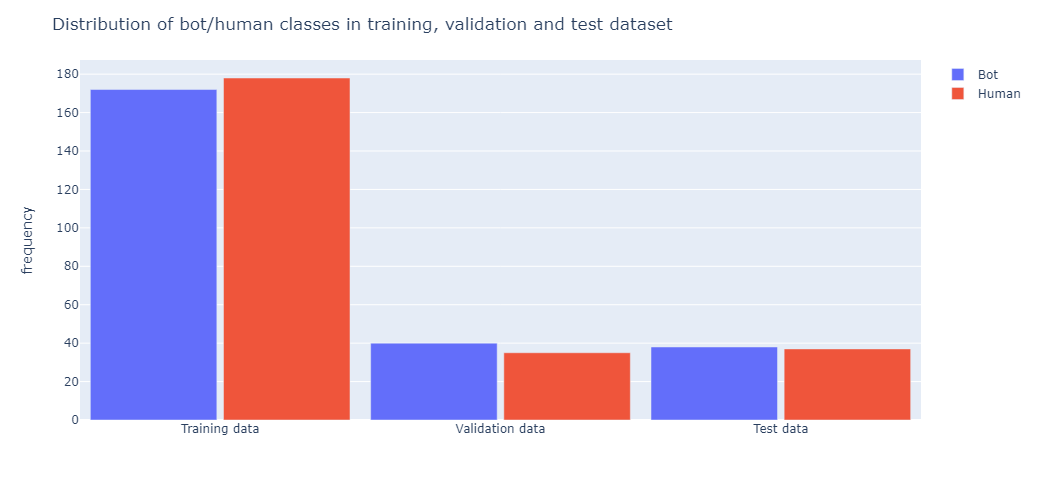

In [66]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [67]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*10 + ['Human']*10,
    'Value': [True]*5 + [False]*5 + [True]*5 + [False]*5,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

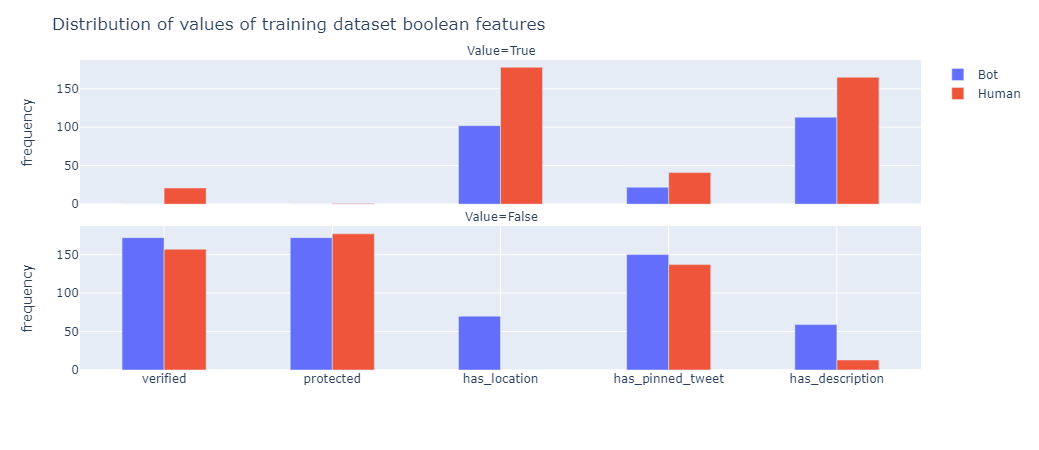

In [68]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

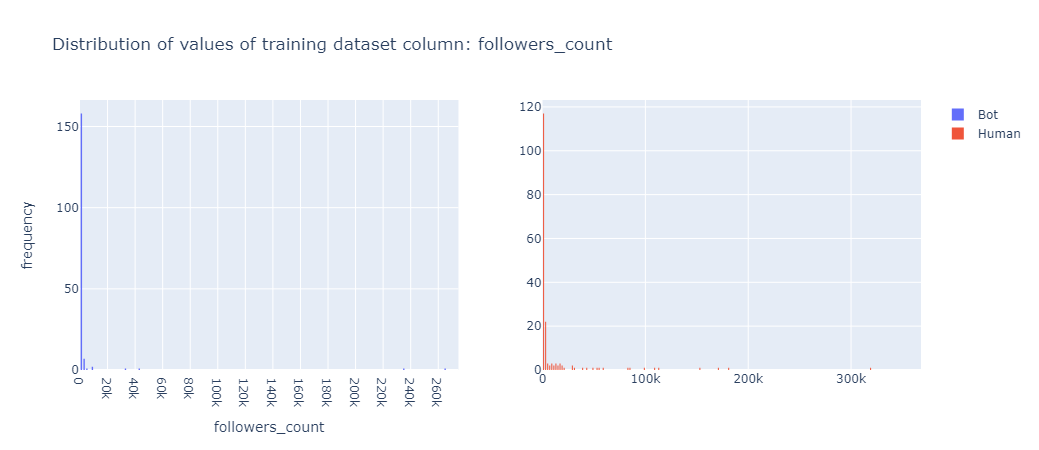

In [69]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000, range=[0, max(train_data.loc[train_data['label']==1,'followers_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=100000, range=[0, max(train_data.loc[train_data['label']==0,'followers_count'])+50000]),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  72


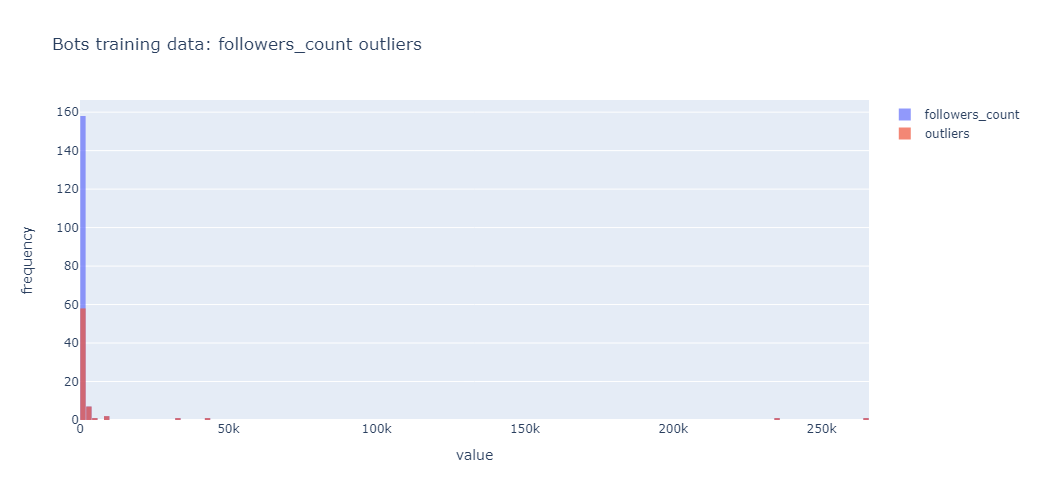

<Figure size 1500x700 with 0 Axes>

In [70]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  119


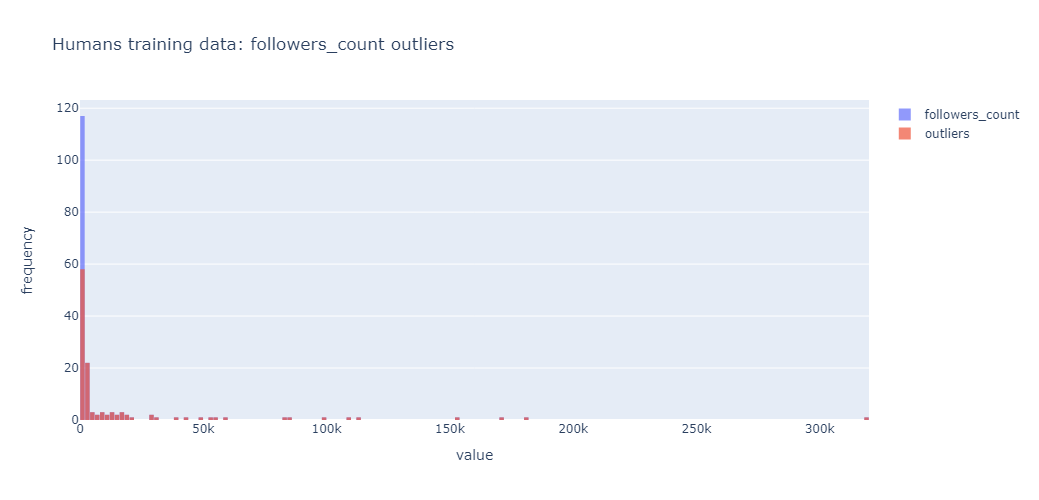

<Figure size 1500x700 with 0 Axes>

In [71]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [72]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [73]:
len(train_data[(train_data['label']==1)])

172

In [74]:
len(train_data[(train_data['label']==0)])

178

In [75]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [76]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [77]:
len(df_filtered_bots)

168

In [78]:
len(df_filtered_humans)

167

In [79]:
len(df_reduced_outliers_followers_count) 

335

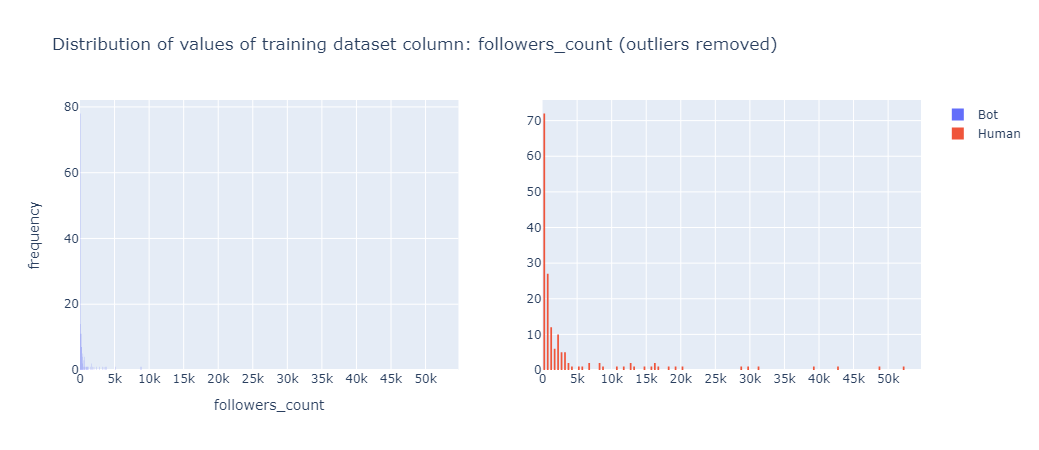

In [80]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

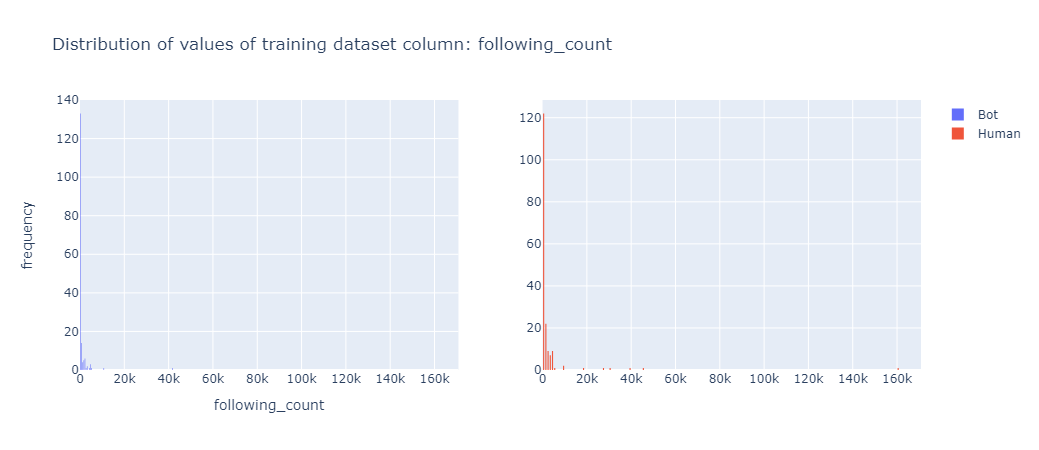

In [81]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [82]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

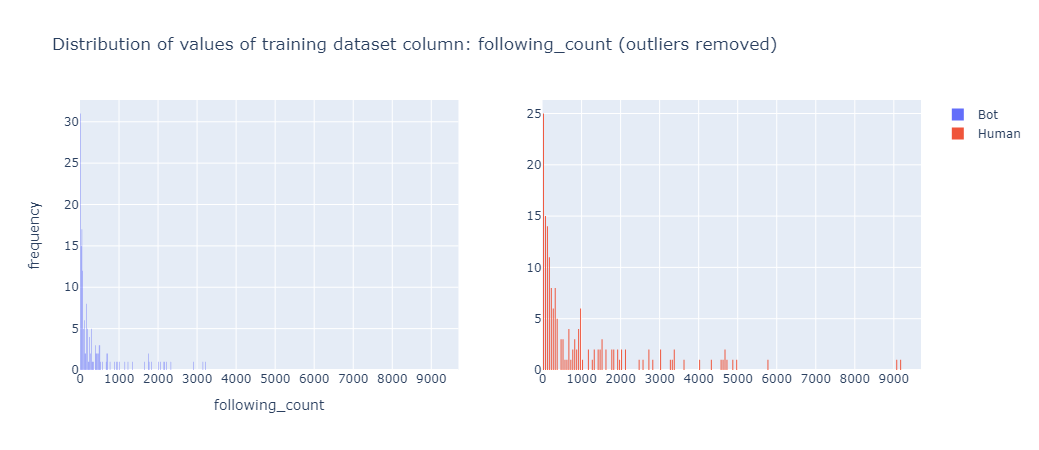

In [83]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

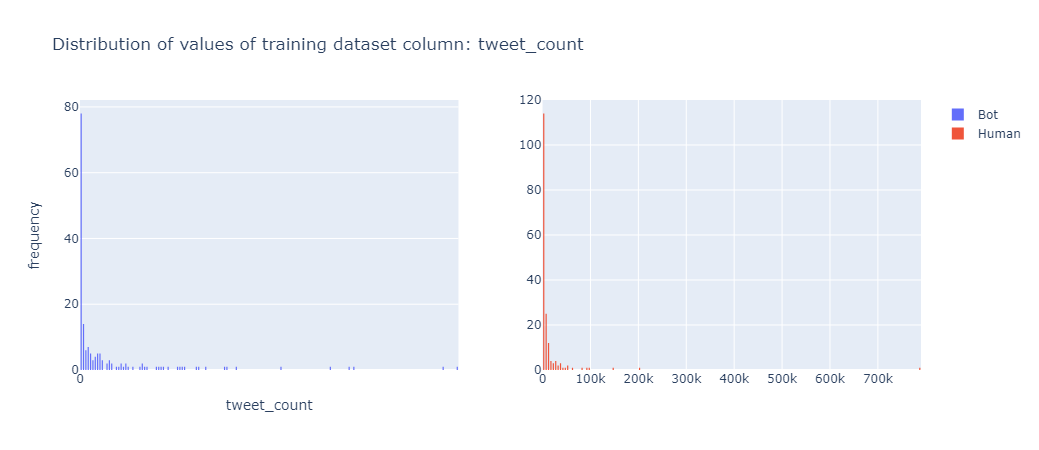

In [84]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [85]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

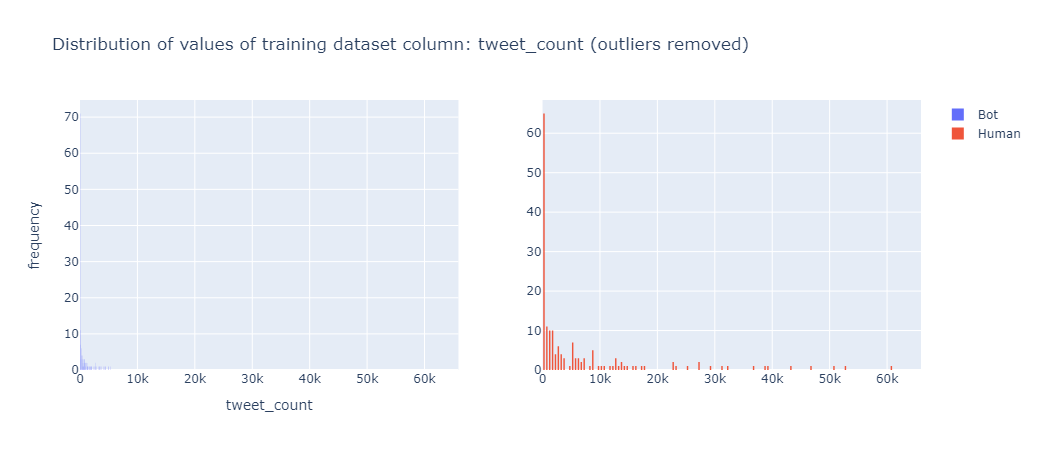

In [86]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    xaxis2=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

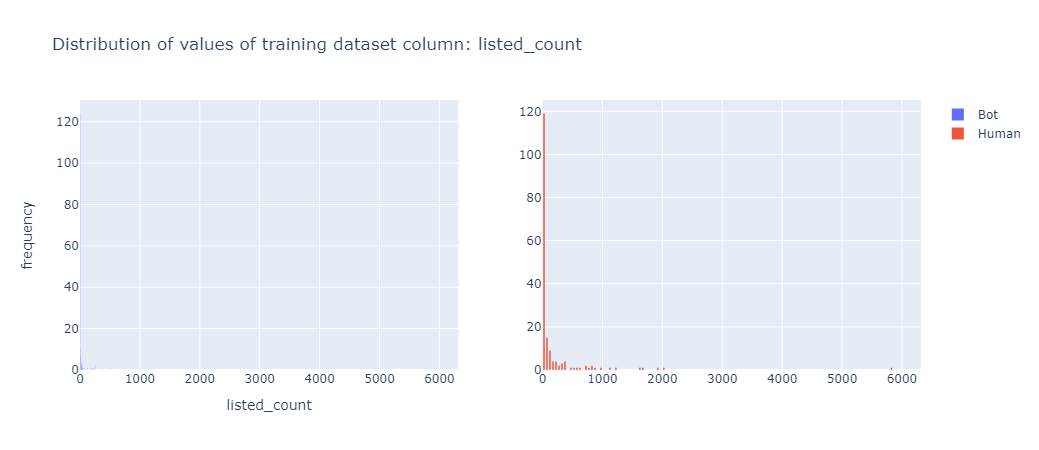

In [87]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [88]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

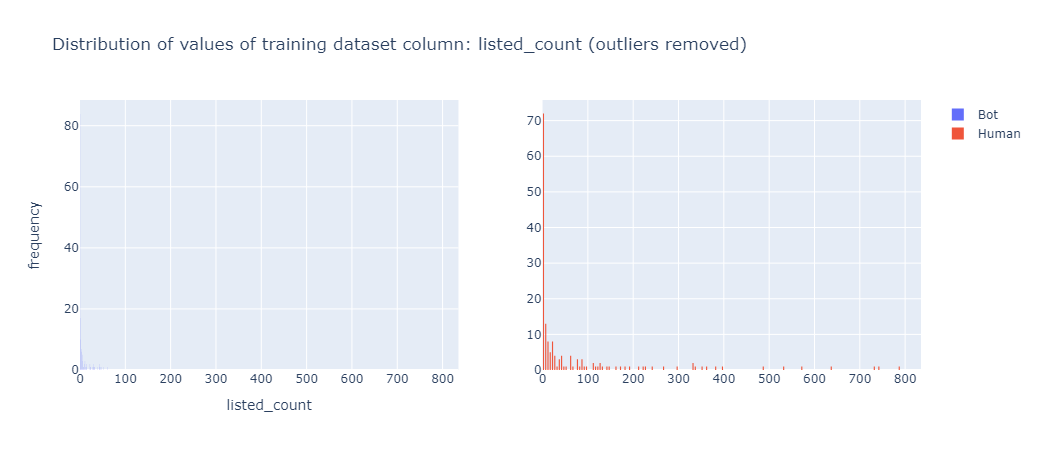

In [89]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    xaxis2=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

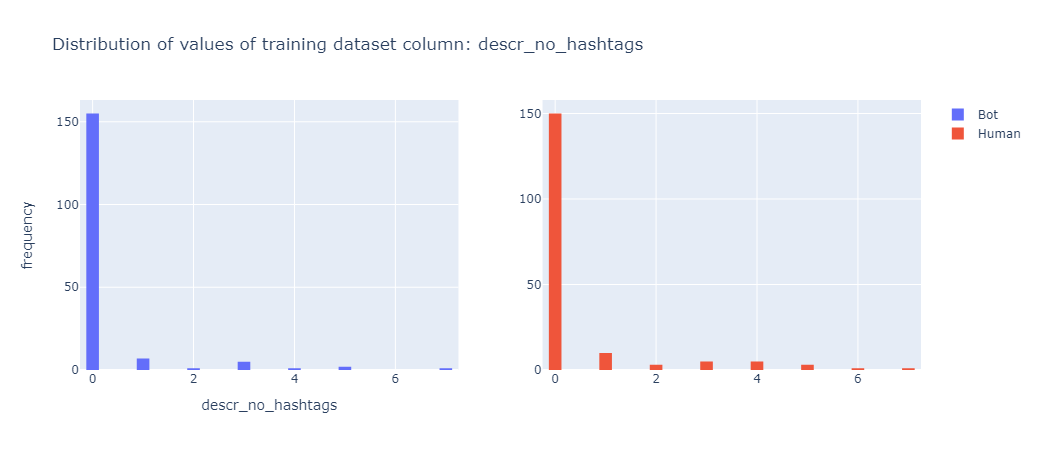

In [90]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [91]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

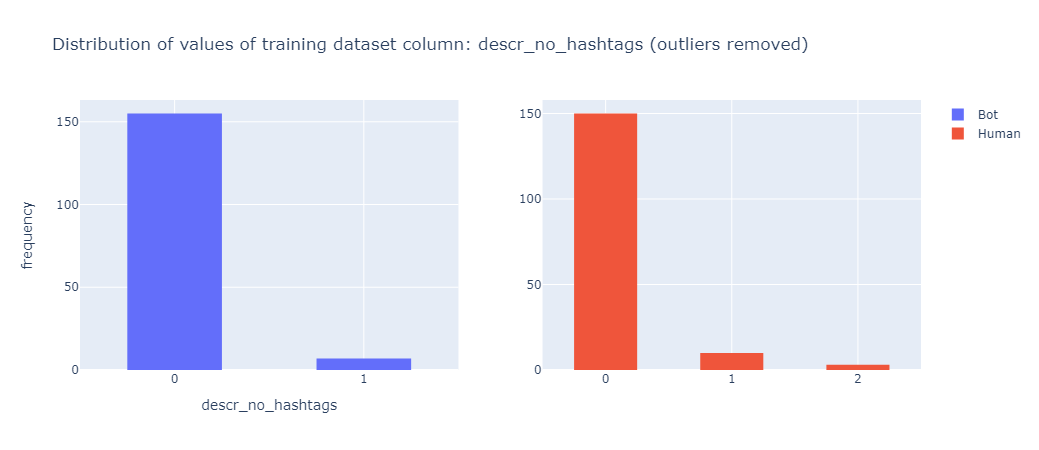

In [92]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


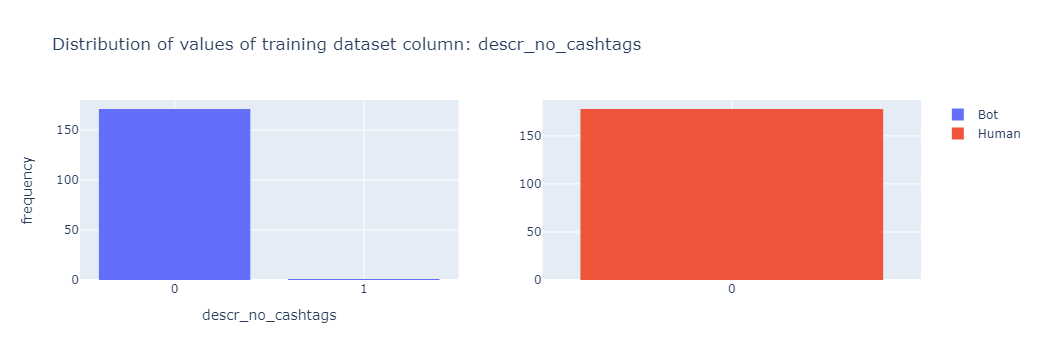

In [93]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [94]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



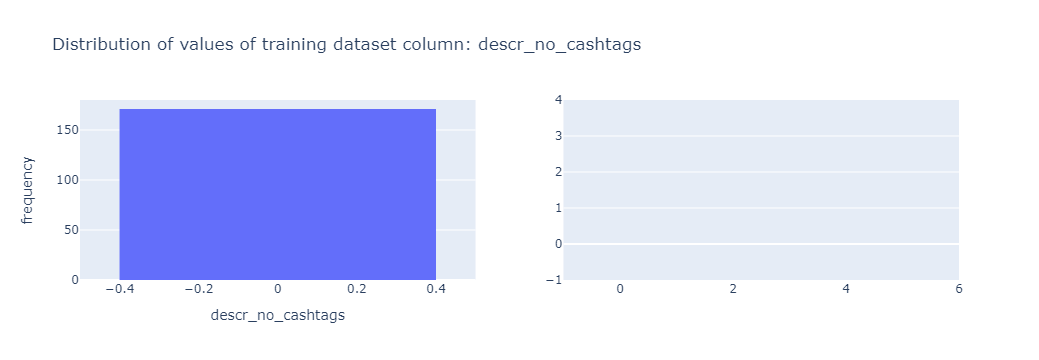

In [95]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1),
    # xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

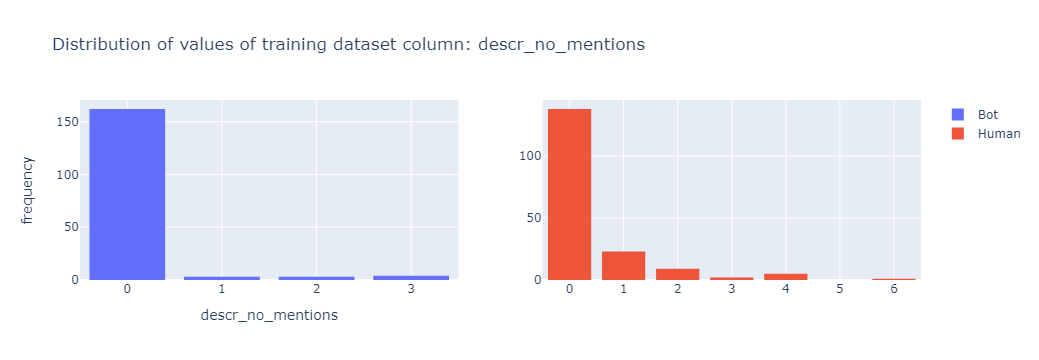

In [96]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [97]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

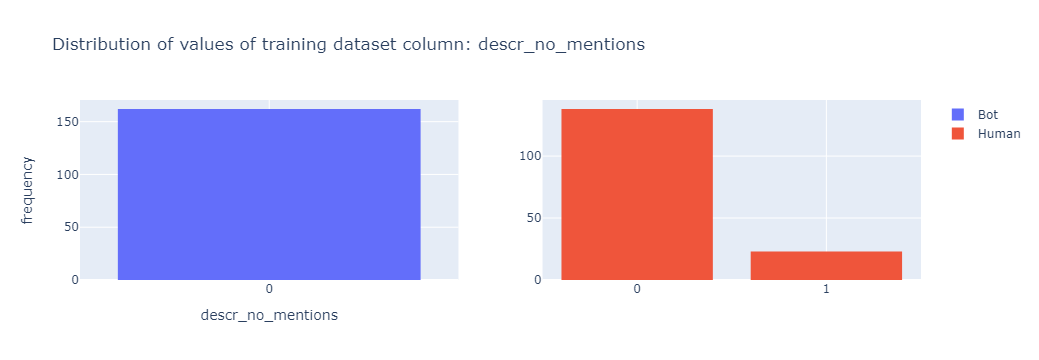

In [98]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

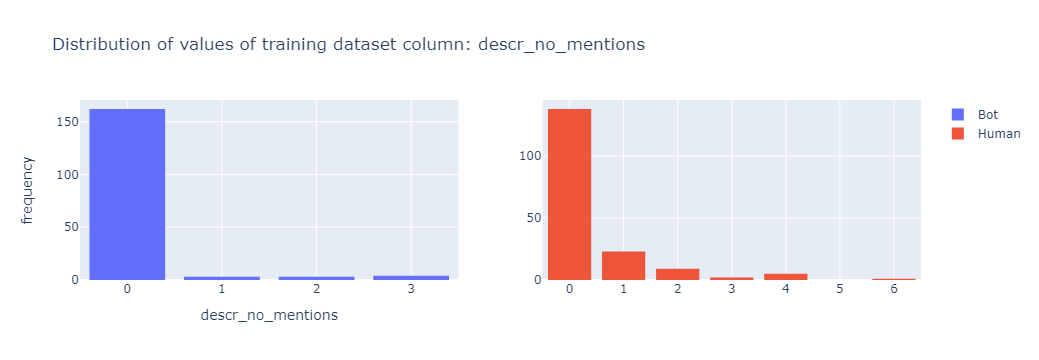

In [99]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [100]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

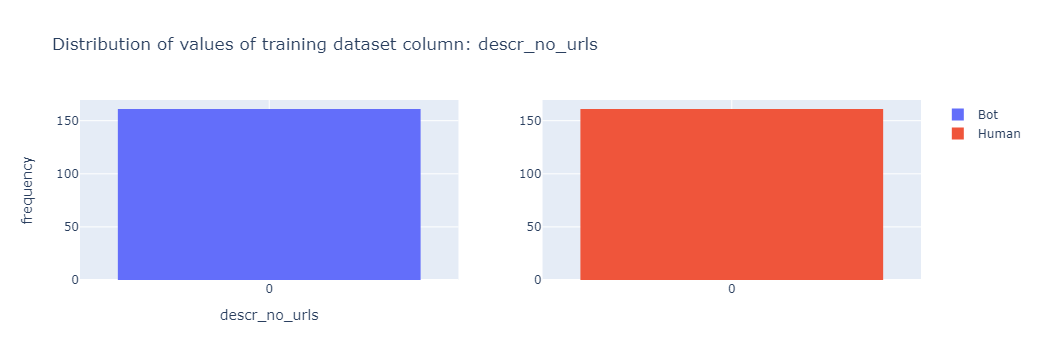

In [101]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

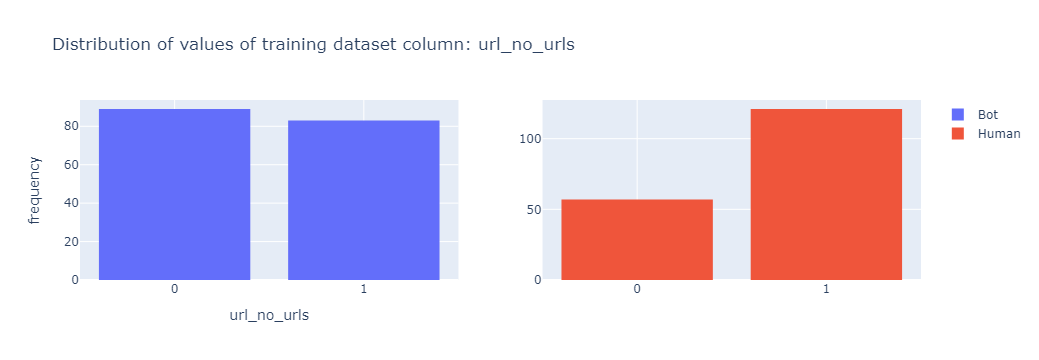

In [102]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [103]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

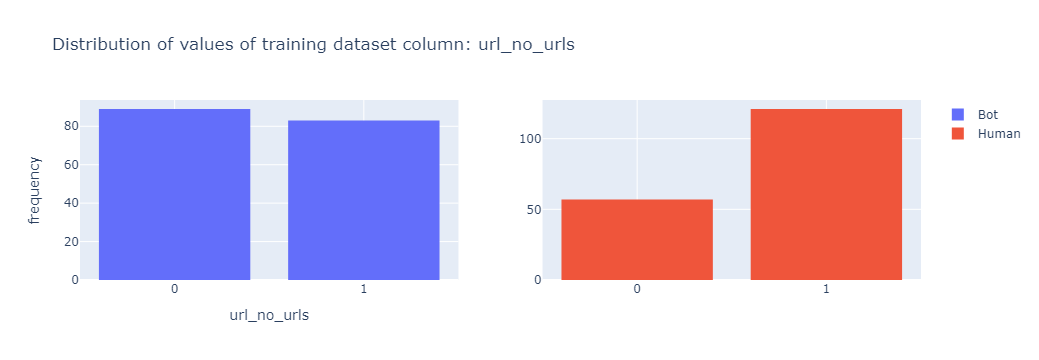

In [104]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

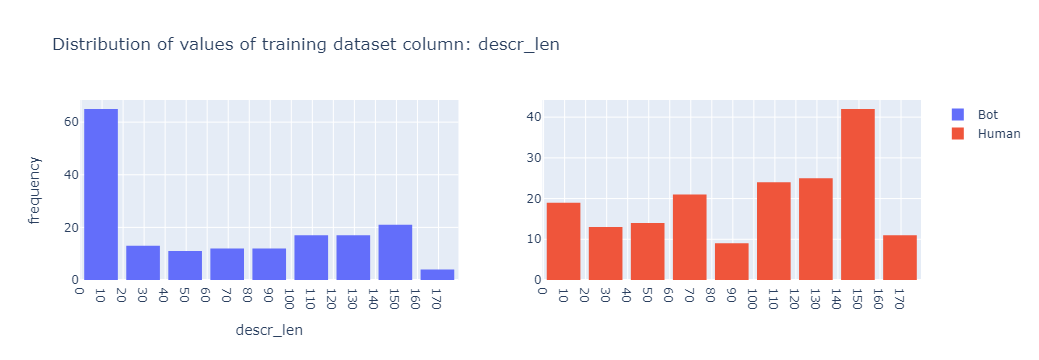

In [105]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [106]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

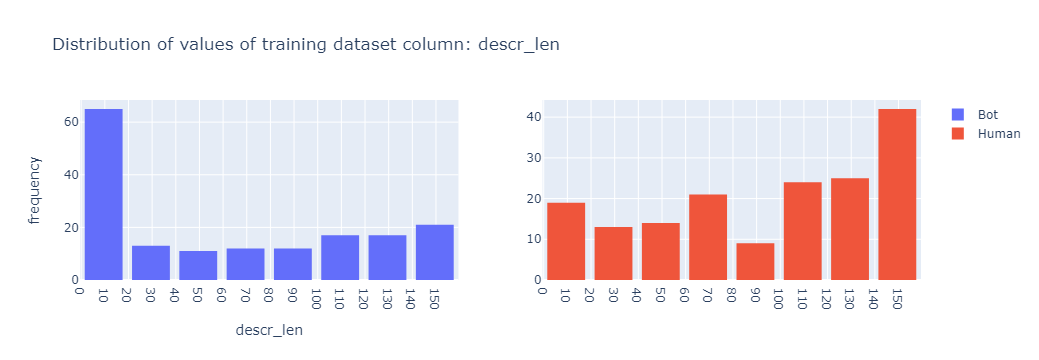

In [107]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

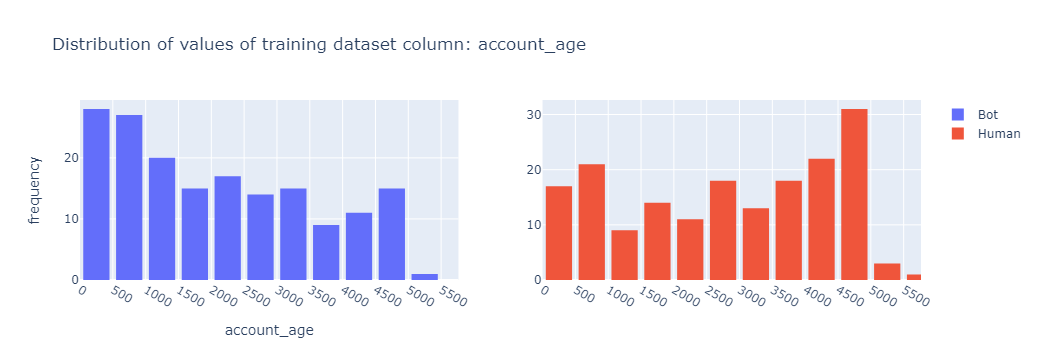

In [108]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [109]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

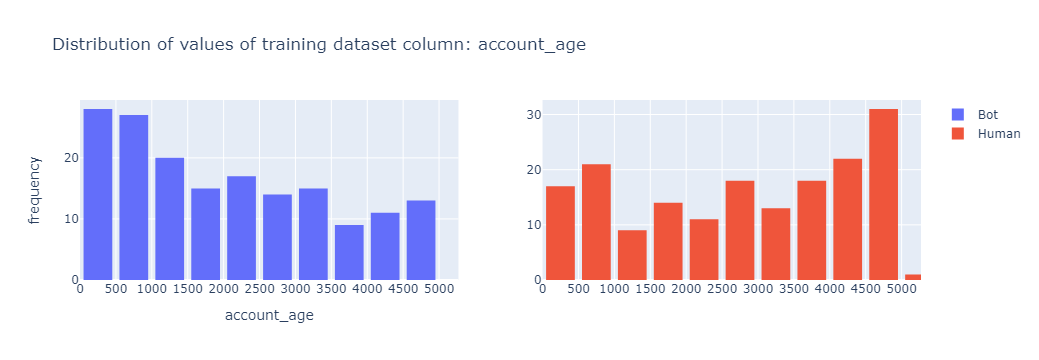

In [110]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [111]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [112]:
len(train_data)

350

In [113]:
len(train_data_wo_outliers)

235

In [114]:
train_data_wo_outliers

id  label  verified  protected  has_location  has_pinned_tweet  \
0    1.972143e+08    0.0       0.0        0.0           1.0               0.0   
1    1.242475e+18    0.0       0.0        0.0           1.0               0.0   
2    8.781038e+17    1.0       0.0        0.0           1.0               0.0   
3    1.126422e+18    1.0       0.0        0.0           0.0               0.0   
4    8.971595e+17    0.0       0.0        0.0           1.0               0.0   
..            ...    ...       ...        ...           ...               ...   
230  1.659154e+08    0.0       0.0        0.0           1.0               1.0   
231  4.953350e+08    0.0       0.0        0.0           1.0               0.0   
232  2.900063e+09    1.0       0.0        0.0           0.0               0.0   
233  8.724894e+07    0.0       0.0        0.0           1.0               0.0   
234  1.931782e+09    1.0       0.0        0.0           0.0               0.0   

     followers_count  following_count  tweet_count  listed_count  \
0             1057.0           1824.0        994.0          43.0   
1                3.0             10.0          4.0           0.0   
2               14.0            388.0          1.0           0.0   
3                6.0             34.0         31.0           0.0   
4               11.0             12.0          1.0           0.0   
..               ...              ...          ...           ...   
230            796.0            335.0       2663.0          16.0   
231           1847.0           1166.0       8953.0         122.0   
232            829.0            522.0        846.0          11.0   
233           1818.0            921.0       8957.0          62.0   
234             12.0            117.0        670.0           0.0   

     has_description  descr_no_hashtags  descr_no_cashtags  descr_no_mentions  \
0                1.0                0.0                0.0                0.0   
1                1.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   
..               ...                ...                ...                ...   
230              1.0                0.0                0.0                1.0   
231              1.0                0.0                0.0                0.0   
232              1.0                0.0                0.0                0.0   
233              1.0                0.0                0.0                0.0   
234              1.0                0.0                0.0                0.0   

     descr_no_urls  url_no_urls  descr_len  account_age  
0              0.0          1.0       55.0       4185.0  
1              0.0          0.0       39.0        722.0  
2              0.0          0.0        0.0       1727.0  
3              0.0          0.0        0.0       1042.0  
4              0.0          0.0        0.0       1675.0  
..             ...          ...        ...          ...  
230            0.0          0.0      139.0       4265.0  
231            0.0          1.0      159.0       3680.0  
232            0.0          1.0      103.0       2662.0  
233            0.0          1.0       42.0       4516.0  
234            0.0          1.0      118.0       3086.0  

[235 rows x 18 columns]

#### Drop 'id' column

In [115]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [116]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  172
Number of human users:  172
Number of bots:  35
Number of human users:  35
Number of bots:  37
Number of human users:  37


In [117]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  111
Number of human users:  111
Number of bots:  35
Number of human users:  35
Number of bots:  37
Number of human users:  37


#### First drop columns in dataframes where there are same value in whole columns in training dataset

In [118]:
same_data_columns = list(train_data.columns[train_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [119]:
train_data = train_data.drop(same_data_columns, axis=1)

val_data = val_data.drop(same_data_columns, axis=1)
test_data = test_data.drop(same_data_columns, axis=1)

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [120]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['descr_no_cashtags', 'descr_no_urls']

In [121]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

## Correlation

In [122]:
sns.set(font_scale=2.5)

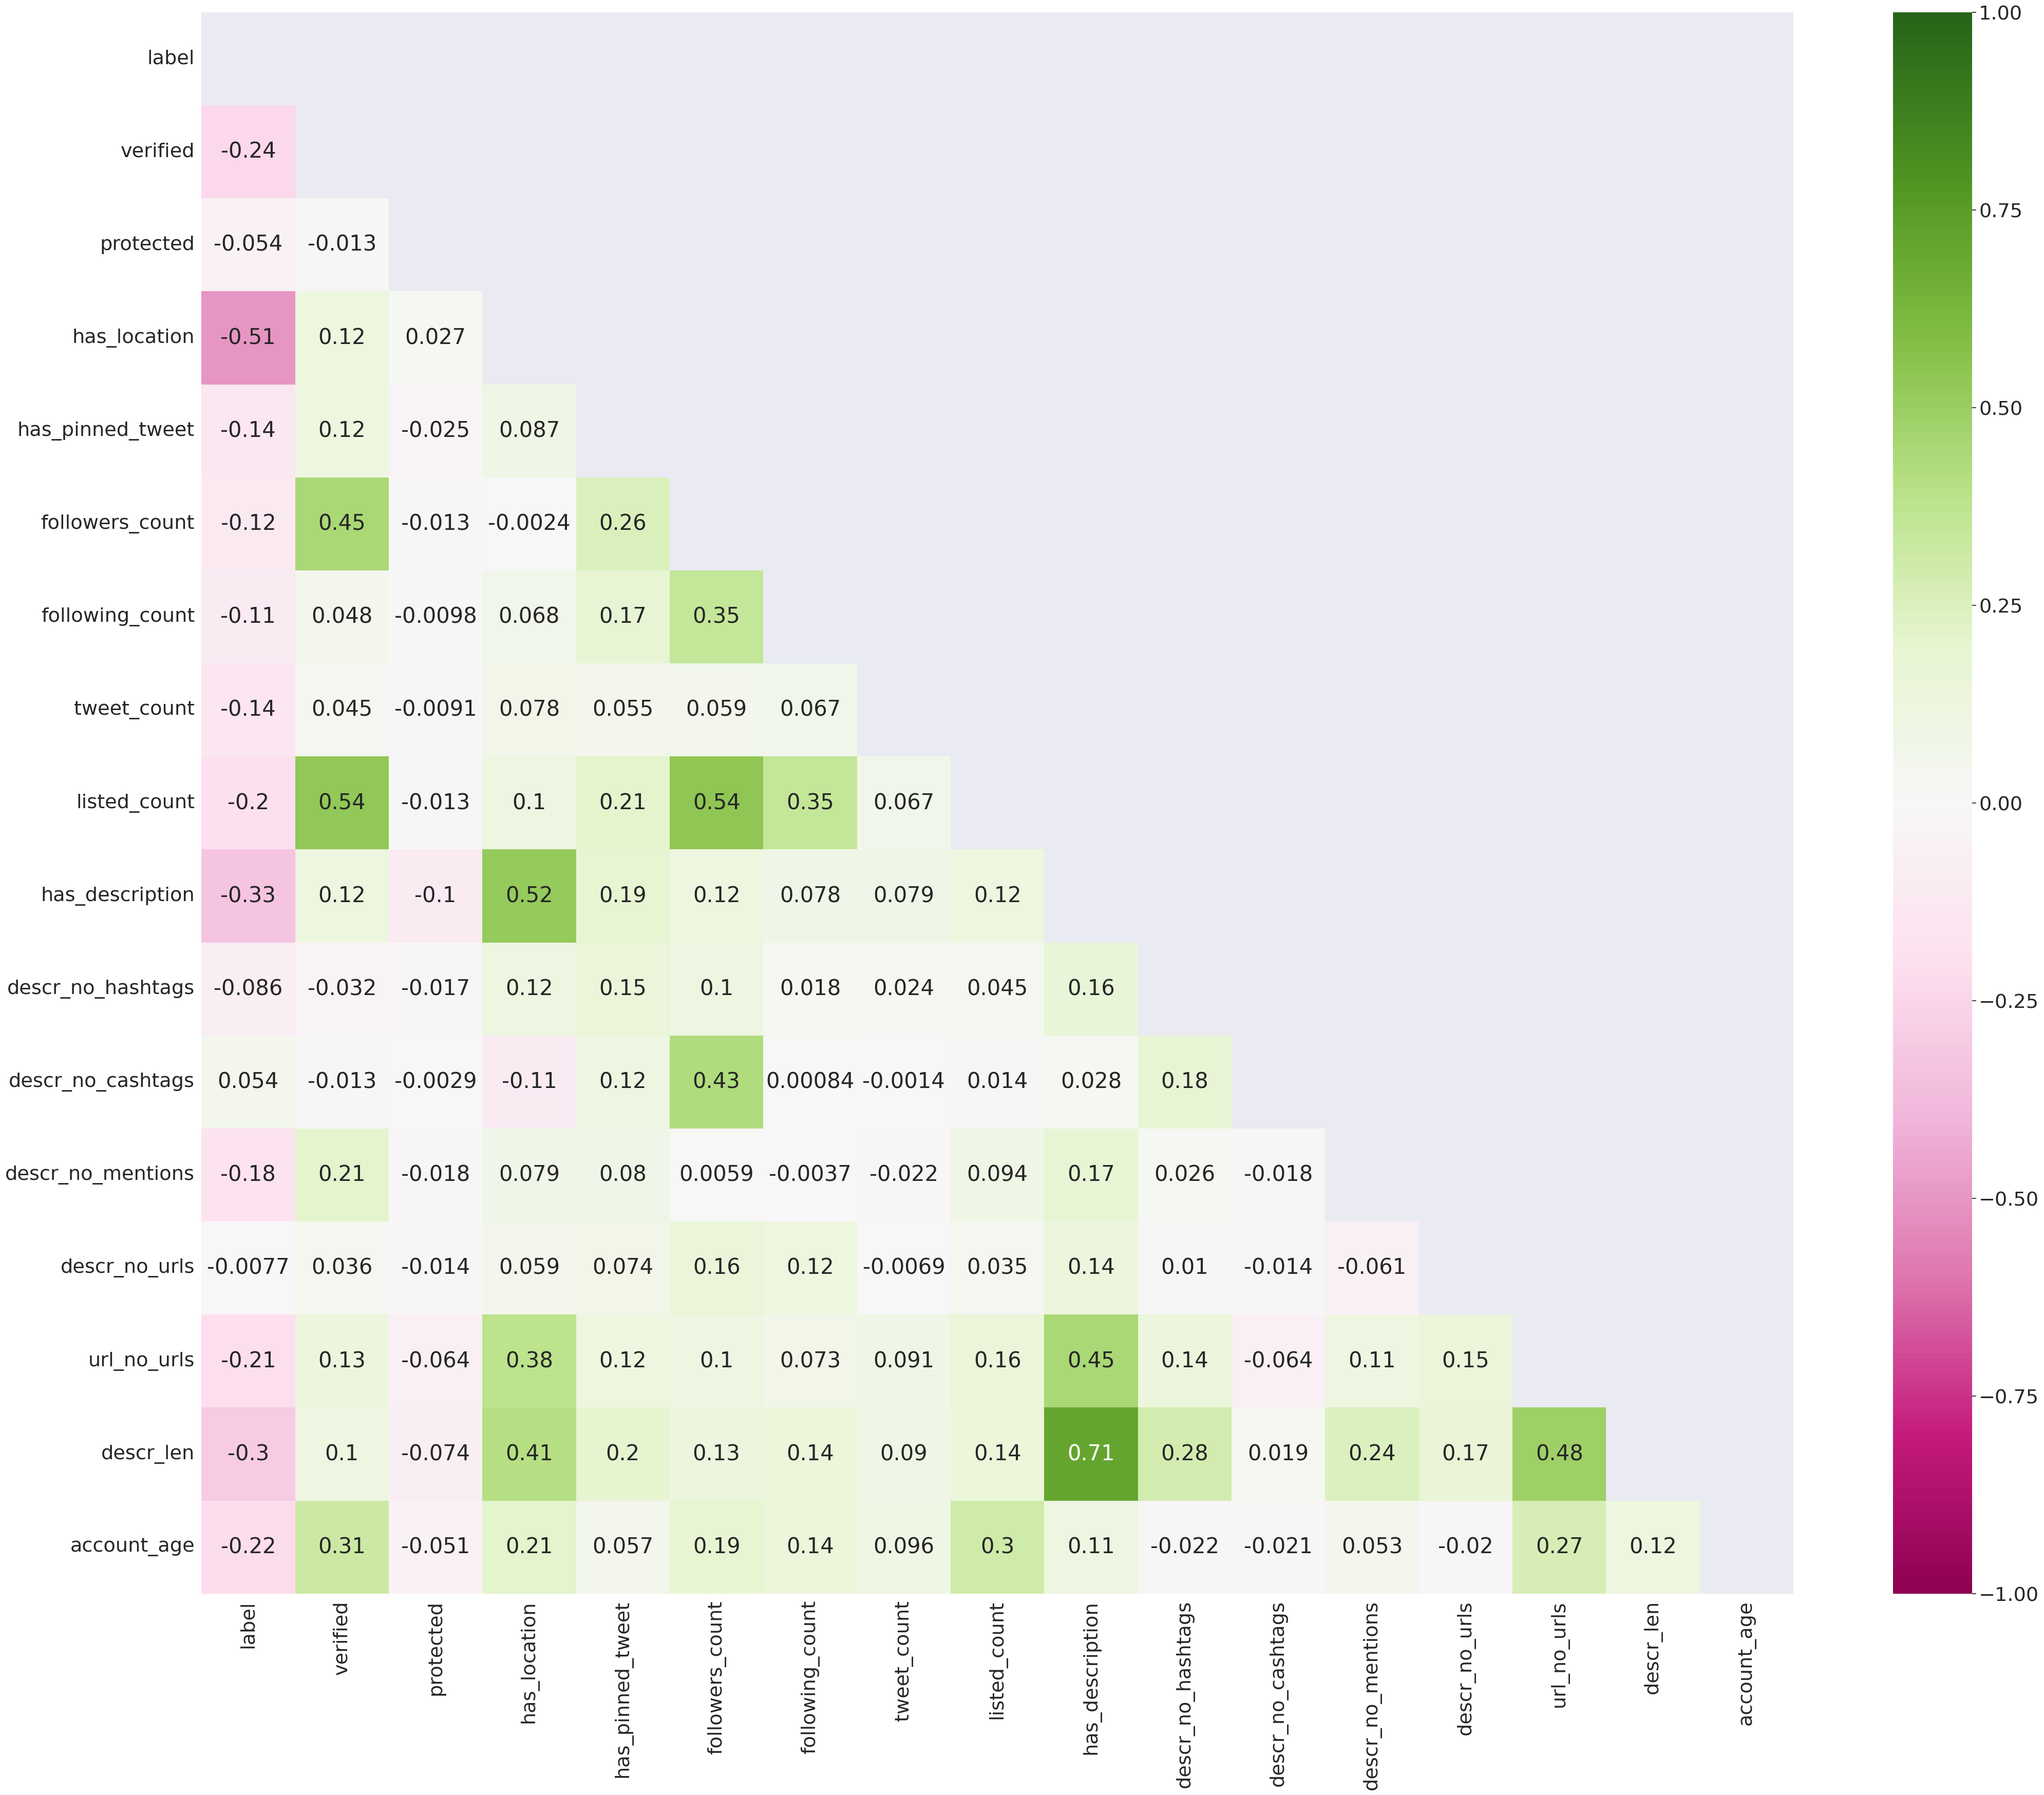

In [123]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [124]:
sns.set(font_scale=1)

In [128]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 4


[('has_description', 'descr_len', 0.7086122806407509),
 ('followers_count', 'listed_count', 0.5428757605249538),
 ('verified', 'listed_count', 0.5375177470421449),
 ('has_location', 'has_description', 0.5209239682737024)]

In [129]:
train_data

label  verified  protected  has_location  has_pinned_tweet  \
169    0.0       0.0        0.0           1.0               0.0   
19     0.0       0.0        0.0           1.0               0.0   
30     1.0       0.0        0.0           1.0               0.0   
102    1.0       0.0        0.0           1.0               0.0   
286    1.0       0.0        0.0           0.0               0.0   
..     ...       ...        ...           ...               ...   
428    1.0       0.0        0.0           0.0               1.0   
374    1.0       0.0        0.0           0.0               0.0   
474    1.0       0.0        0.0           1.0               0.0   
318    1.0       0.0        0.0           0.0               0.0   
132    1.0       0.0        0.0           1.0               0.0   

     followers_count  following_count  tweet_count  descr_no_hashtags  \
169           1057.0           1824.0        994.0                0.0   
19               3.0             10.0          4.0                0.0   
30              14.0            388.0          1.0                0.0   
102             66.0             33.0        367.0                0.0   
286              6.0             34.0         31.0                0.0   
..               ...              ...          ...                ...   
428            201.0            160.0         99.0                0.0   
374            829.0            522.0        846.0                0.0   
474           8708.0          10660.0        869.0                0.0   
318             12.0            117.0        670.0                0.0   
132            363.0            289.0       1282.0                0.0   

     descr_no_cashtags  descr_no_mentions  descr_no_urls  descr_len  \
169                0.0                0.0            0.0       55.0   
19                 0.0                0.0            0.0       39.0   
30                 0.0                0.0            0.0        0.0   
102                0.0                1.0            0.0       29.0   
286                0.0                0.0            0.0        0.0   
..                 ...                ...            ...        ...   
428                0.0                0.0            0.0        0.0   
374                0.0                0.0            0.0      103.0   
474                0.0                0.0            0.0      157.0   
318                0.0                0.0            0.0      118.0   
132                0.0                1.0            0.0      107.0   

     account_age  
169       4185.0  
19         722.0  
30        1727.0  
102       2144.0  
286       1042.0  
..           ...  
428       1132.0  
374       2662.0  
474       4716.0  
318       3086.0  
132       4697.0  

[344 rows x 14 columns]

In [132]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

train_data = train_data.drop(['has_location'], axis=1)
val_data = val_data.drop(['has_location'], axis=1)
test_data = test_data.drop(['has_location'], axis=1)

### Correlation of data reduced by outliers

#### Correlation

In [133]:
sns.set(font_scale=2)

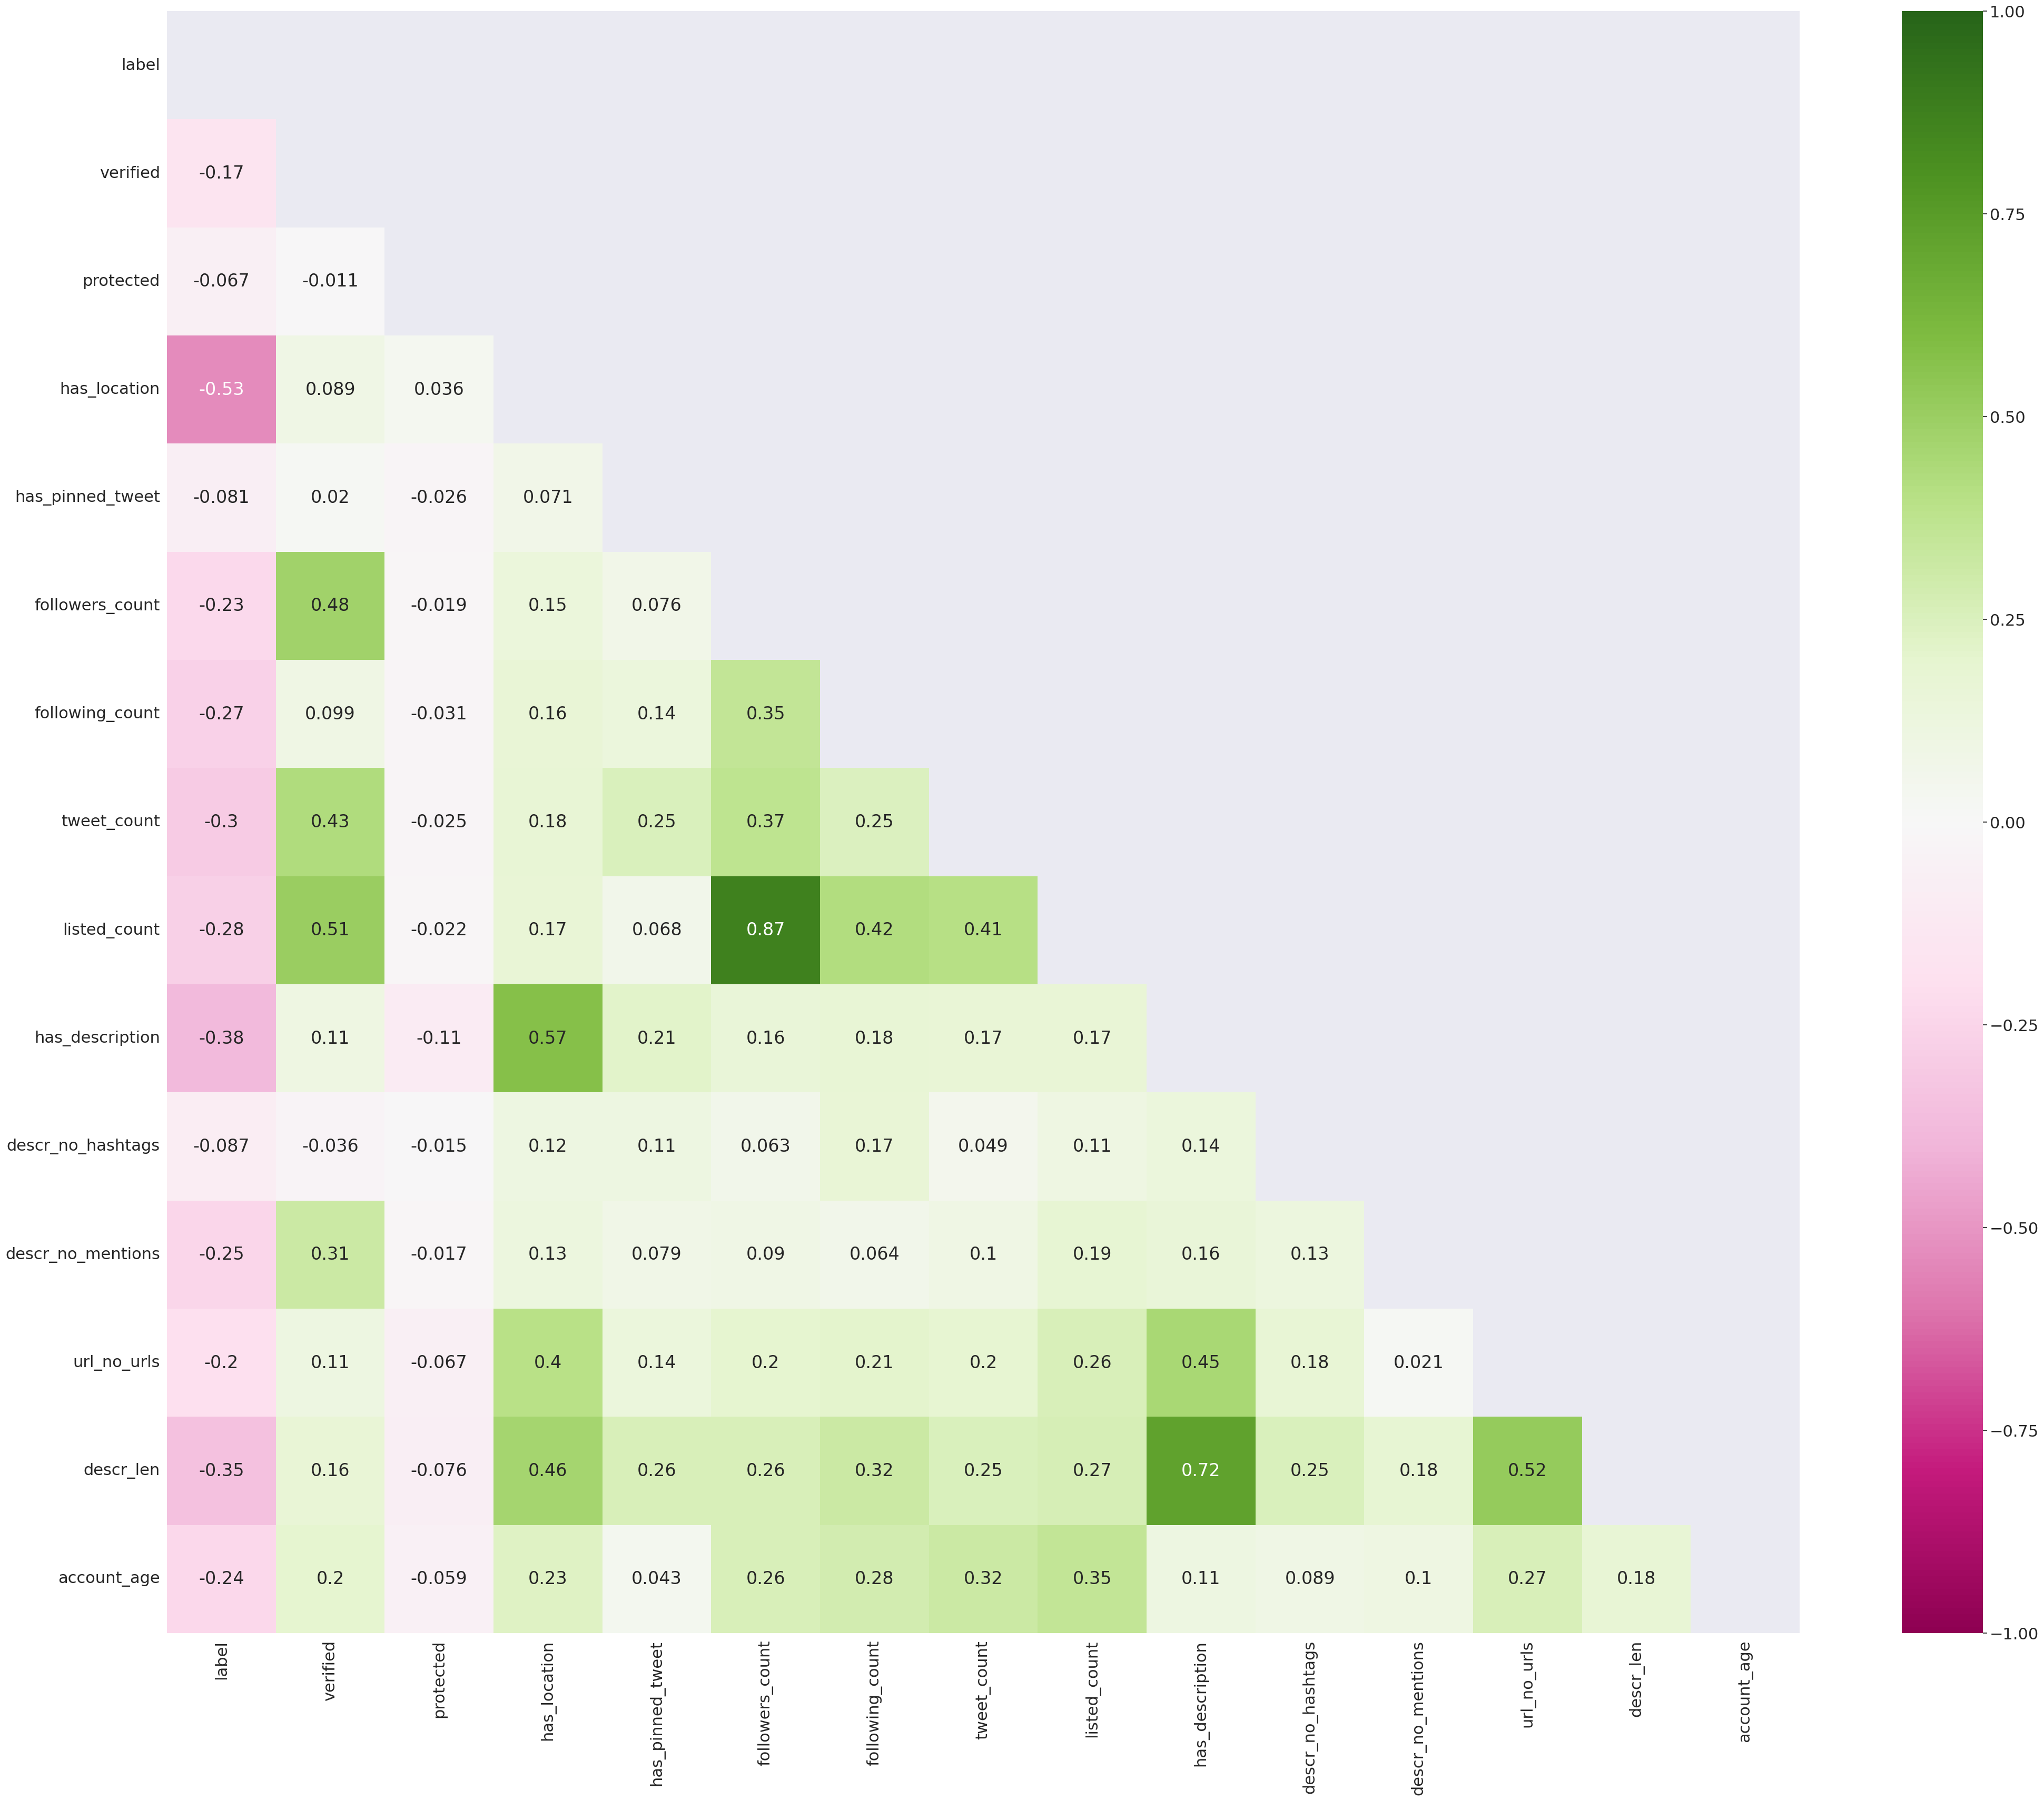

In [134]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [135]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [136]:
high_corr2

[('followers_count', 'listed_count', 0.8730037891466388),
 ('has_description', 'descr_len', 0.7194893182489059),
 ('has_location', 'has_description', 0.5724482704336712),
 ('label', 'has_location', -0.5322001448887942)]

In [137]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description',  'has_location'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location'], axis=1)

#### Split data for input and output

In [138]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [139]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [140]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [141]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [142]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [143]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [144]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-27 16:54:13.534731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-27 16:54:13.534786: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-27 16:54:13.534818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a983cdf753bc): /proc/driver/nvidia/version does not exist
2023-08-27 16:54:13.536412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=300

#### Create and train model

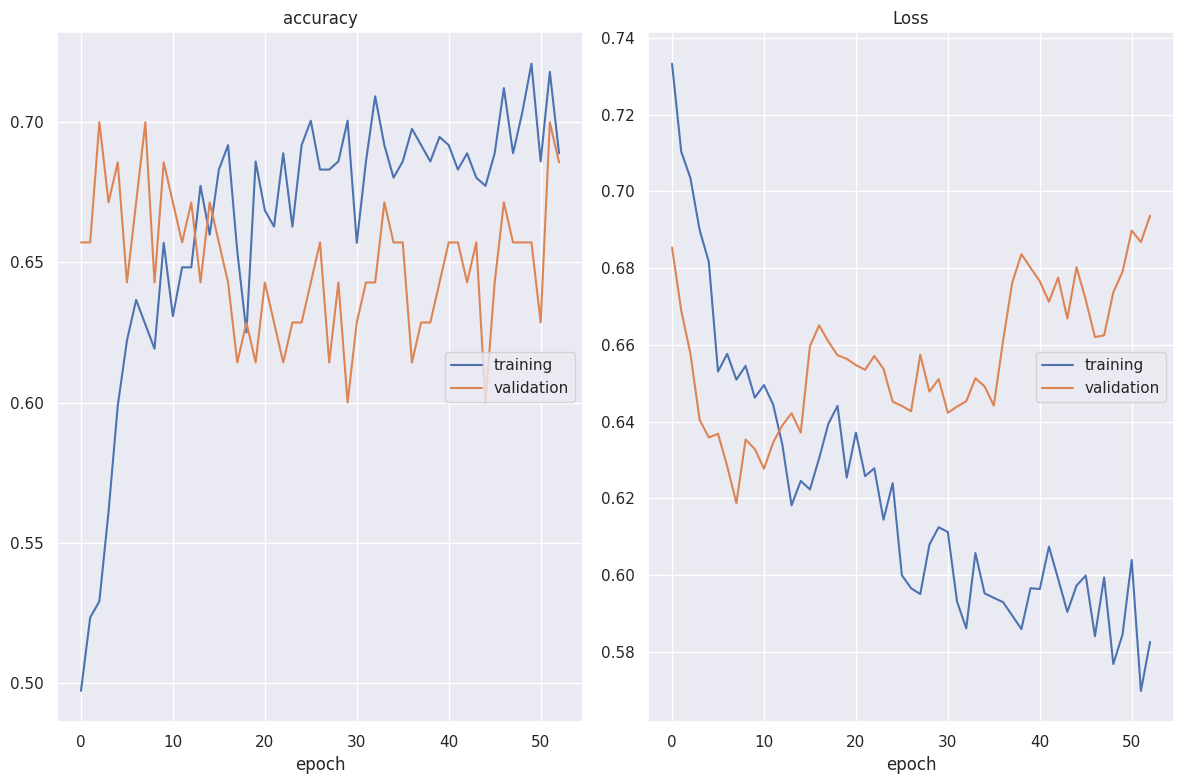

accuracy
	training         	 (min:    0.497, max:    0.721, cur:    0.689)
	validation       	 (min:    0.600, max:    0.700, cur:    0.686)
Loss
	training         	 (min:    0.570, max:    0.733, cur:    0.583)
	validation       	 (min:    0.619, max:    0.694, cur:    0.694)

Epoch 53: val_accuracy did not improve from 0.70000
35/35 [==============================] - 1s 18ms/step - loss: 0.5826 - accuracy: 0.6890 - val_loss: 0.6937 - val_accuracy: 0.6857


In [145]:
model_name = 'model_users_only_500_1_v1_batch_size_10'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.581081081081081
Precision: [0.60714286 0.56521739]
Recall: 0.7027027027027027
F1 score: 0.626506
ROC AUC: 0.581081


(0.581081081081081,
 array([0.60714286, 0.56521739]),
 0.7027027027027027,
 0.6265060240963856,
 0.581081081081081)

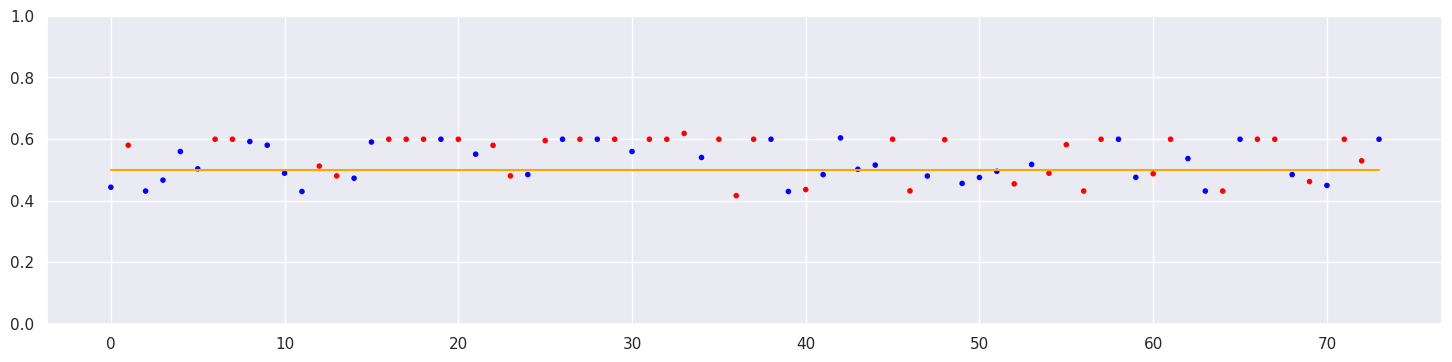

<Figure size 640x480 with 0 Axes>

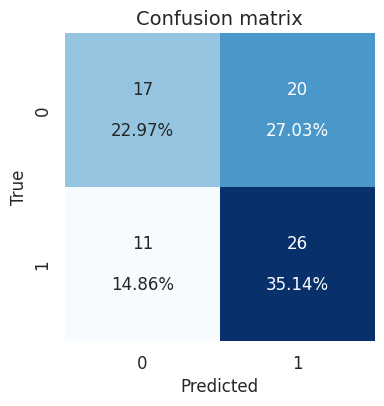

In [146]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=300

In [147]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                416       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

### Train model

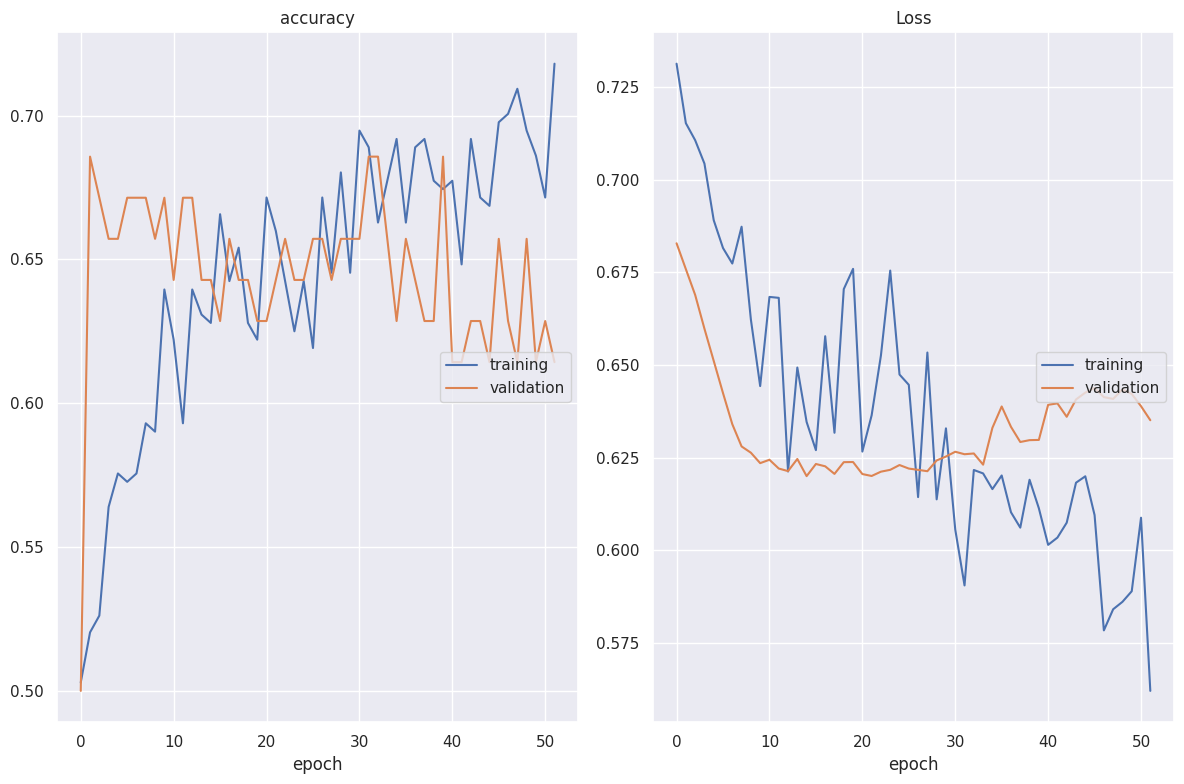

accuracy
	training         	 (min:    0.503, max:    0.718, cur:    0.718)
	validation       	 (min:    0.500, max:    0.686, cur:    0.614)
Loss
	training         	 (min:    0.562, max:    0.731, cur:    0.562)
	validation       	 (min:    0.620, max:    0.683, cur:    0.635)

Epoch 52: val_accuracy did not improve from 0.68571
7/7 [==============================] - 1s 97ms/step - loss: 0.5621 - accuracy: 0.7180 - val_loss: 0.6351 - val_accuracy: 0.6143


In [148]:
model_name = 'model_users_only_500_1_v1_batch_size_50'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=300)

In [149]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [150]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

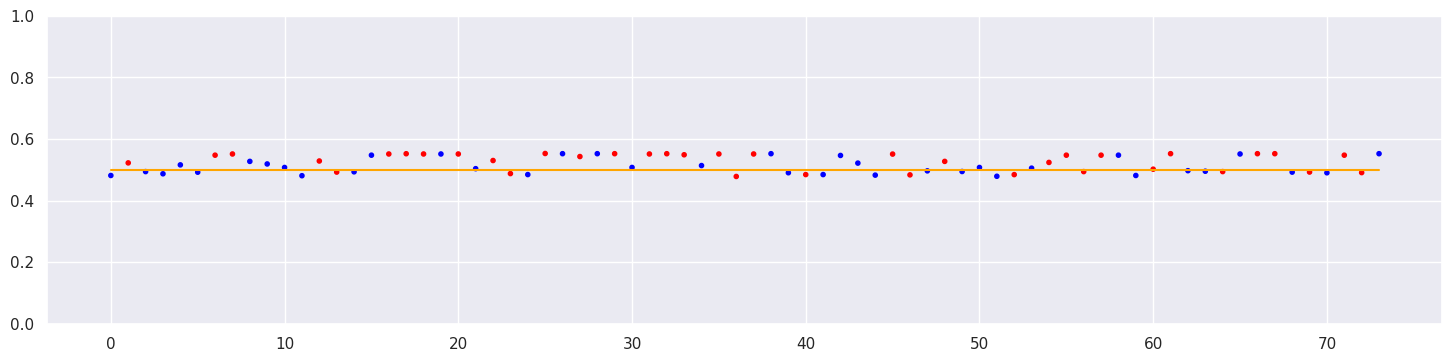

In [151]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.6081081081081081
Precision: [0.64285714 0.58695652]
Recall: 0.7297297297297297
F1 score: 0.650602
ROC AUC: 0.608108


(0.6081081081081081,
 array([0.64285714, 0.58695652]),
 0.7297297297297297,
 0.6506024096385542,
 0.6081081081081081)

<Figure size 640x480 with 0 Axes>

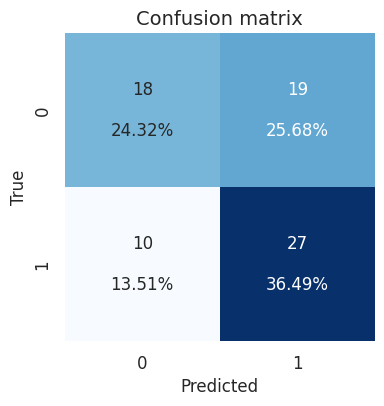

In [152]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=300

#### Create and train model

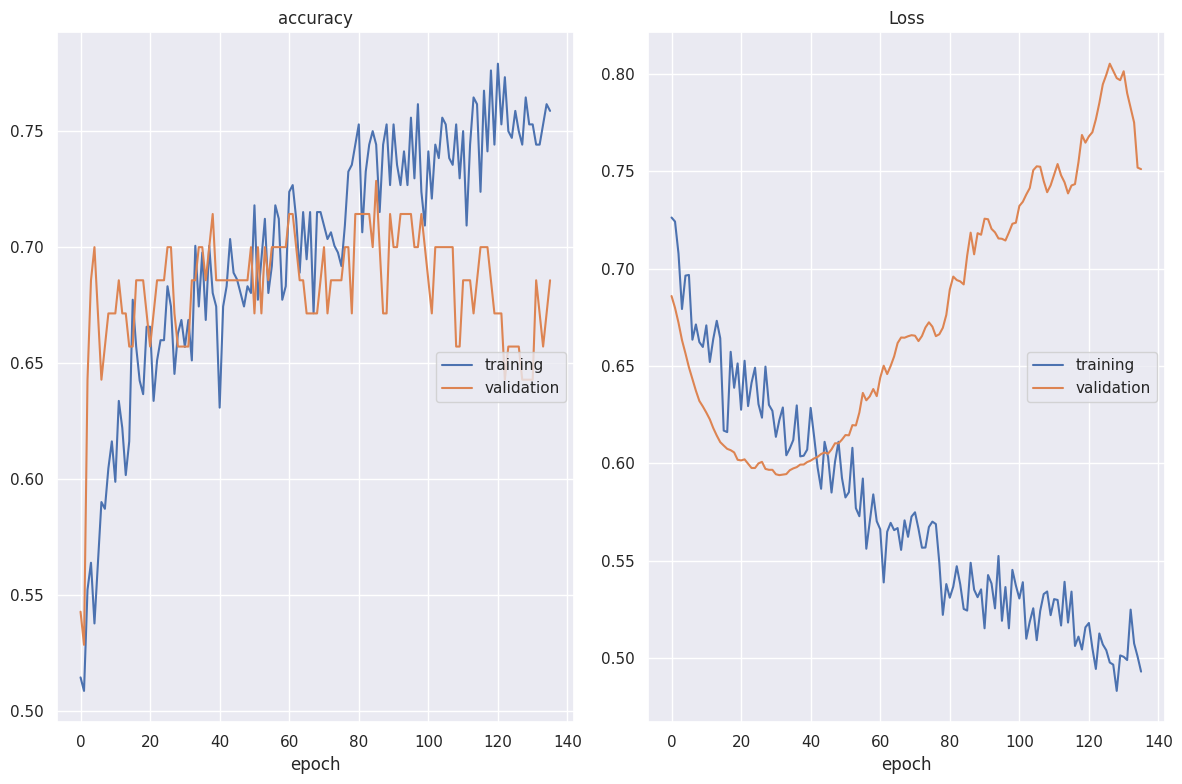

accuracy
	training         	 (min:    0.509, max:    0.779, cur:    0.759)
	validation       	 (min:    0.529, max:    0.729, cur:    0.686)
Loss
	training         	 (min:    0.483, max:    0.726, cur:    0.493)
	validation       	 (min:    0.594, max:    0.805, cur:    0.751)

Epoch 136: val_accuracy did not improve from 0.72857
4/4 [==============================] - 1s 286ms/step - loss: 0.4931 - accuracy: 0.7587 - val_loss: 0.7511 - val_accuracy: 0.6857


In [153]:
model_name = 'model_users_only_500_1_v1_batch_size_100'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.7162162162162162
Precision: [0.71052632 0.72222222]
Recall: 0.7027027027027027
F1 score: 0.712329
ROC AUC: 0.716216


(0.7162162162162162,
 array([0.71052632, 0.72222222]),
 0.7027027027027027,
 0.7123287671232876,
 0.7162162162162162)

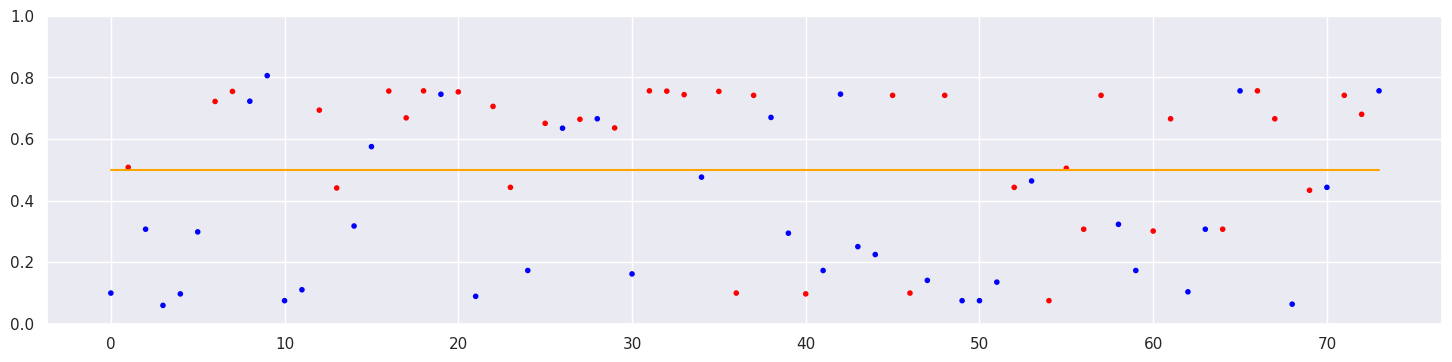

<Figure size 640x480 with 0 Axes>

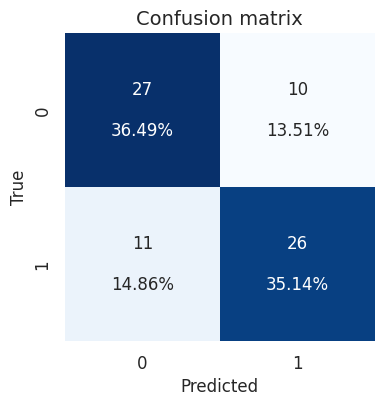

In [154]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=300

#### Create and train model

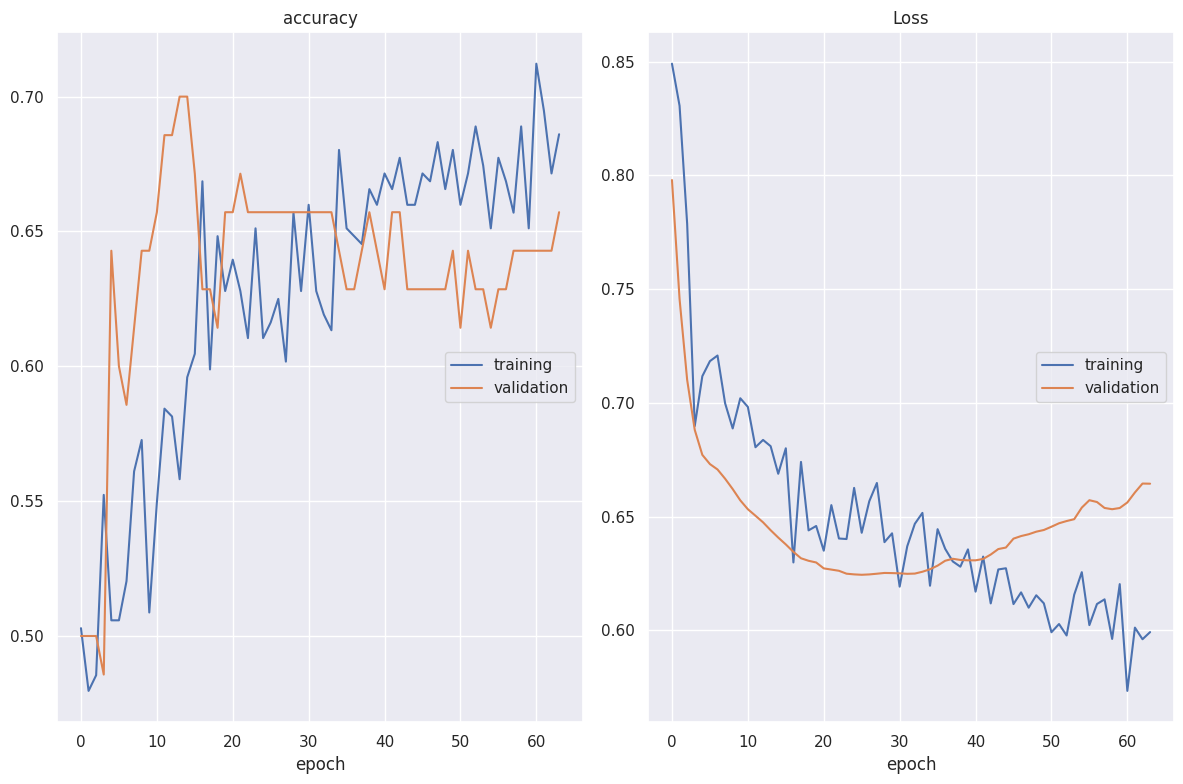

accuracy
	training         	 (min:    0.480, max:    0.712, cur:    0.686)
	validation       	 (min:    0.486, max:    0.700, cur:    0.657)
Loss
	training         	 (min:    0.573, max:    0.849, cur:    0.599)
	validation       	 (min:    0.624, max:    0.798, cur:    0.664)

Epoch 64: val_accuracy did not improve from 0.70000
3/3 [==============================] - 1s 272ms/step - loss: 0.5992 - accuracy: 0.6860 - val_loss: 0.6644 - val_accuracy: 0.6571


In [155]:
model_name = 'model_users_only_500_1_v1_batch_size_150'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6081081081081081
Precision: [0.625     0.5952381]
Recall: 0.6756756756756757
F1 score: 0.632911
ROC AUC: 0.608108


(0.6081081081081081,
 array([0.625    , 0.5952381]),
 0.6756756756756757,
 0.6329113924050633,
 0.6081081081081081)

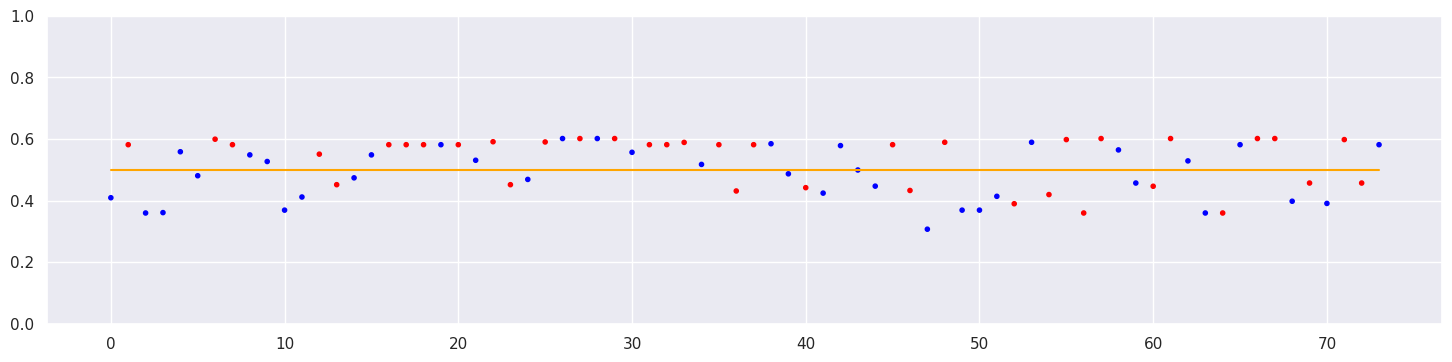

<Figure size 640x480 with 0 Axes>

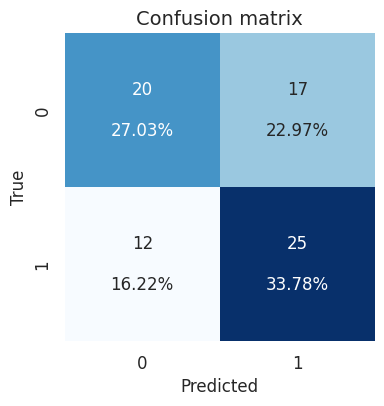

In [156]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=300

#### Create and train model

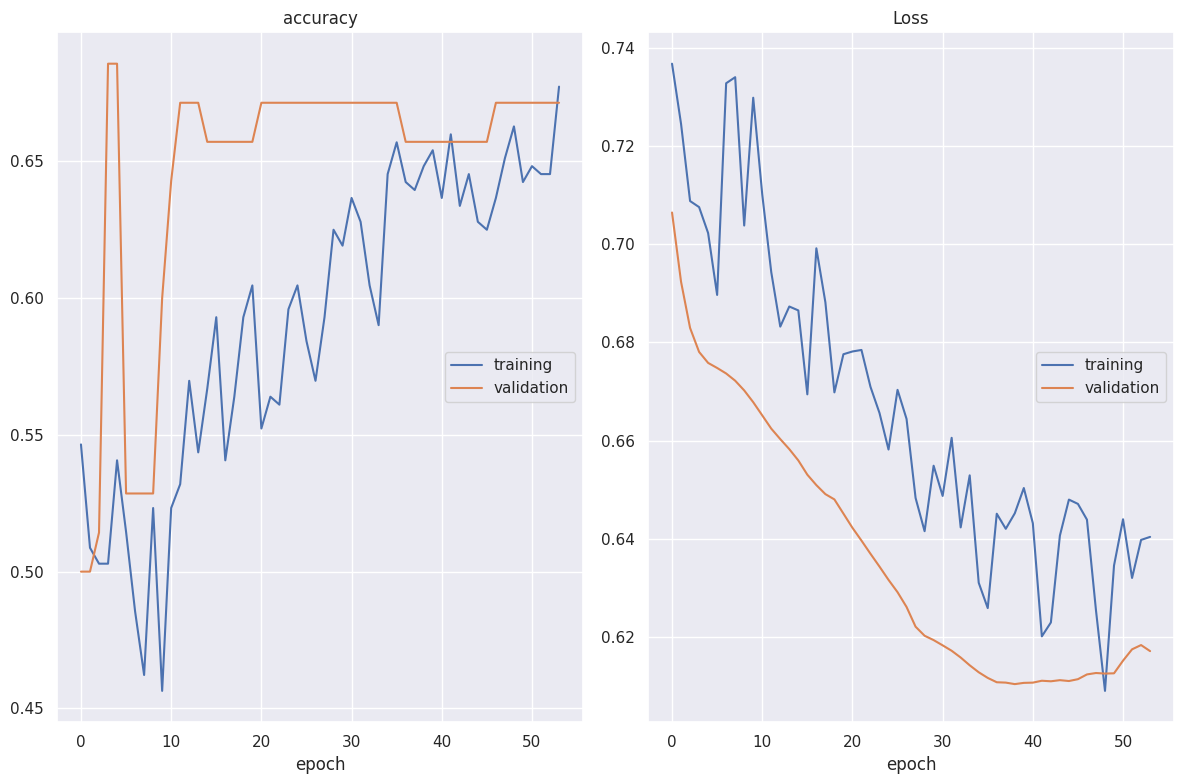

accuracy
	training         	 (min:    0.456, max:    0.677, cur:    0.677)
	validation       	 (min:    0.500, max:    0.686, cur:    0.671)
Loss
	training         	 (min:    0.609, max:    0.737, cur:    0.640)
	validation       	 (min:    0.610, max:    0.706, cur:    0.617)

Epoch 54: val_accuracy did not improve from 0.68571
2/2 [==============================] - 1s 528ms/step - loss: 0.6404 - accuracy: 0.6773 - val_loss: 0.6171 - val_accuracy: 0.6714


In [157]:
model_name = 'model_users_only_500_1_v1_batch_size_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.5540540540540541
Precision: [0.6        0.53703704]
Recall: 0.7837837837837838
F1 score: 0.637363
ROC AUC: 0.554054


(0.5540540540540541,
 array([0.6       , 0.53703704]),
 0.7837837837837838,
 0.6373626373626374,
 0.5540540540540541)

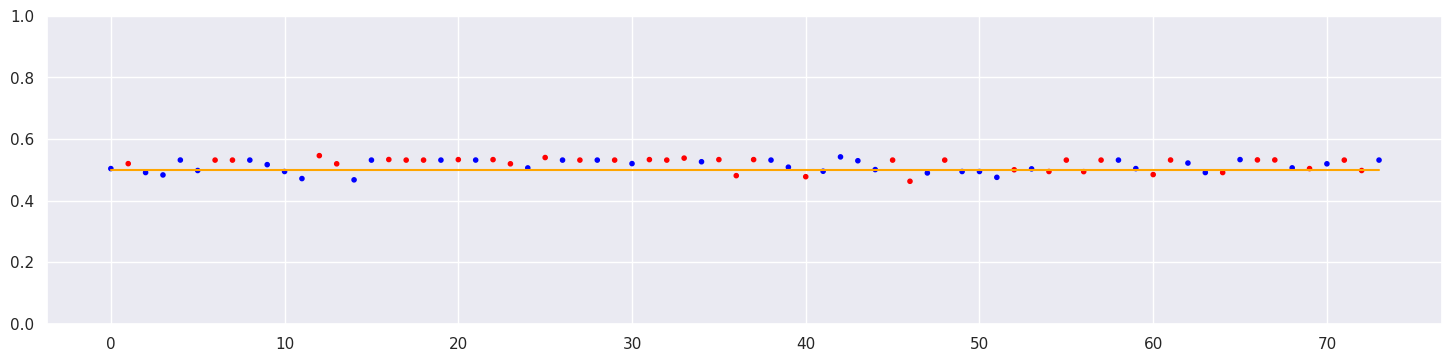

<Figure size 640x480 with 0 Axes>

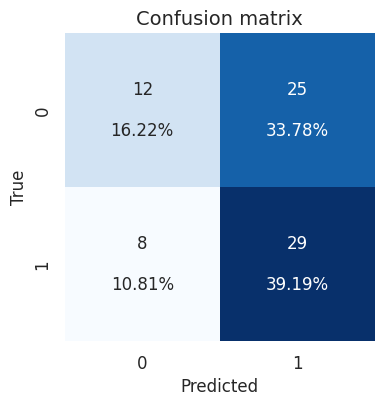

In [158]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=300

#### Create and train model

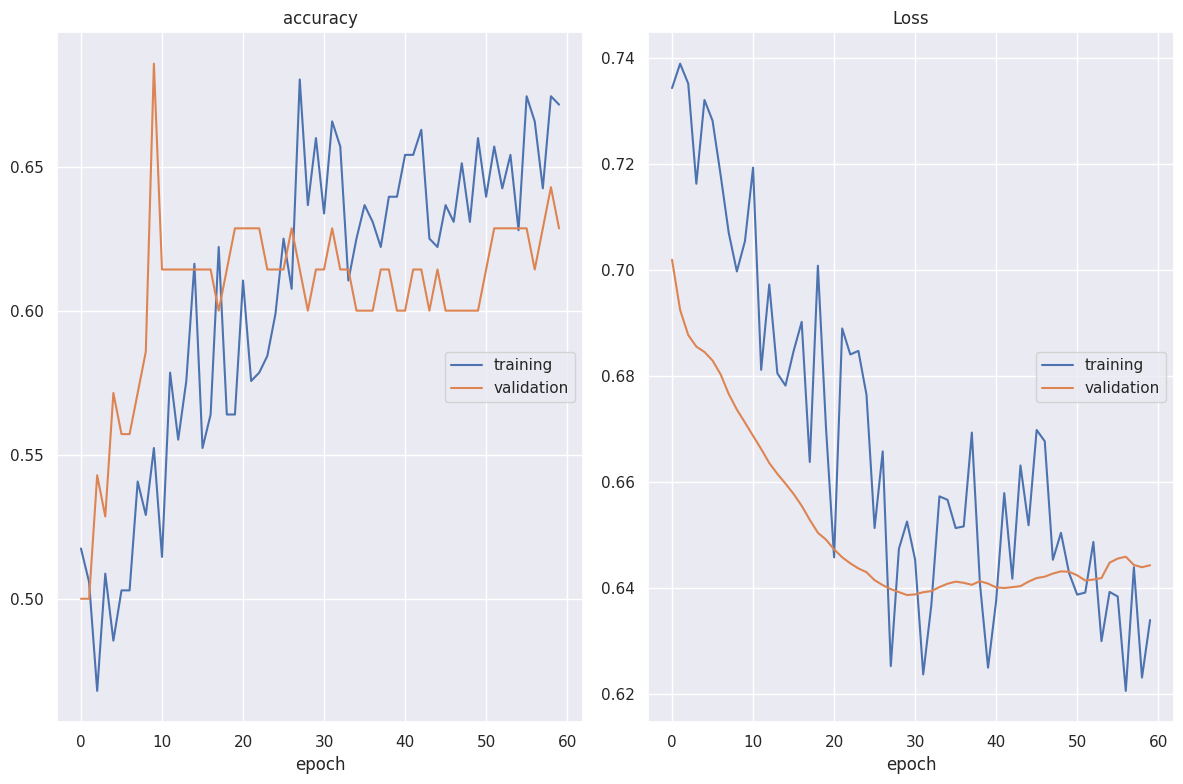

accuracy
	training         	 (min:    0.468, max:    0.680, cur:    0.672)
	validation       	 (min:    0.500, max:    0.686, cur:    0.629)
Loss
	training         	 (min:    0.621, max:    0.739, cur:    0.634)
	validation       	 (min:    0.639, max:    0.702, cur:    0.644)

Epoch 60: val_accuracy did not improve from 0.68571
2/2 [==============================] - 1s 552ms/step - loss: 0.6340 - accuracy: 0.6715 - val_loss: 0.6443 - val_accuracy: 0.6286


In [159]:
model_name = 'model_users_only_500_1_v1_batch_size_250'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6081081081081081
Precision: [0.63333333 0.59090909]
Recall: 0.7027027027027027
F1 score: 0.641975
ROC AUC: 0.608108


(0.6081081081081081,
 array([0.63333333, 0.59090909]),
 0.7027027027027027,
 0.6419753086419754,
 0.6081081081081081)

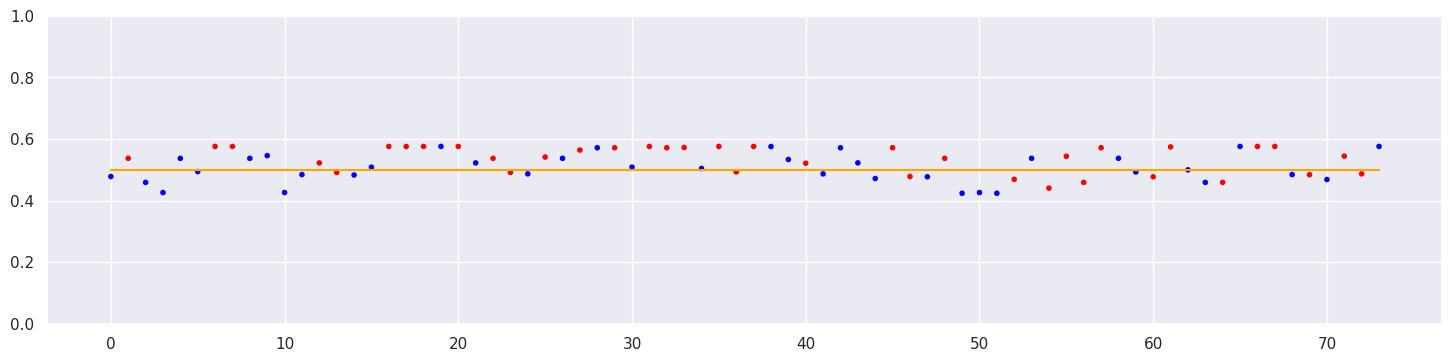

<Figure size 640x480 with 0 Axes>

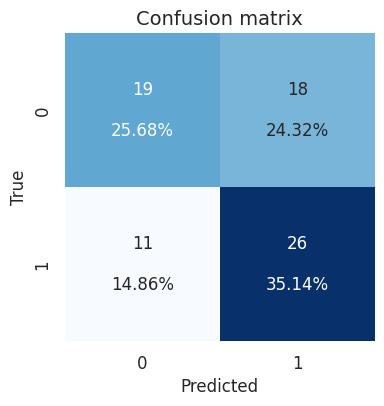

In [160]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=300

#### Create and train model

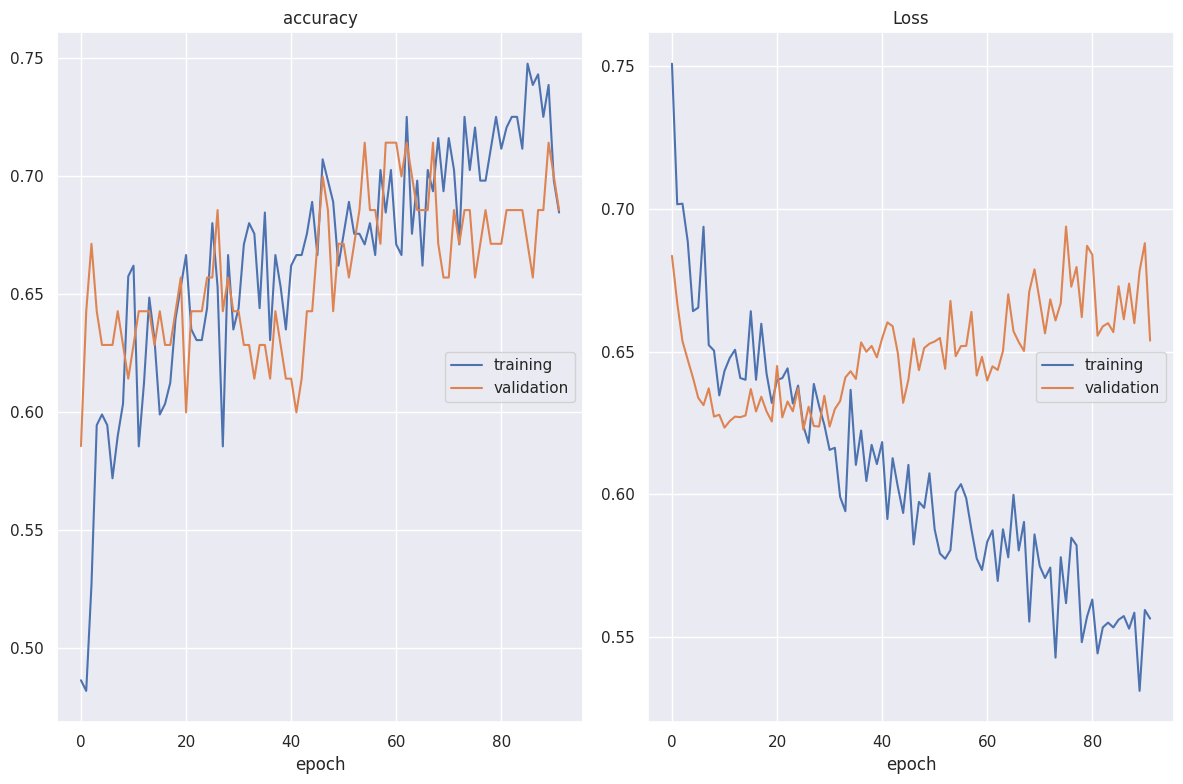

accuracy
	training         	 (min:    0.482, max:    0.748, cur:    0.685)
	validation       	 (min:    0.586, max:    0.714, cur:    0.686)
Loss
	training         	 (min:    0.531, max:    0.751, cur:    0.556)
	validation       	 (min:    0.623, max:    0.694, cur:    0.654)

Epoch 92: val_accuracy did not improve from 0.71429
23/23 [==============================] - 1s 26ms/step - loss: 0.5564 - accuracy: 0.6847 - val_loss: 0.6539 - val_accuracy: 0.6857
Epoch 93/300
 1/23 [>.............................] - ETA: 0s - loss: 0.6219 - accuracy: 0.7000

In [ ]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_10'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=300)

#### Prediction and results

In [ ]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=300

#### Create and train model

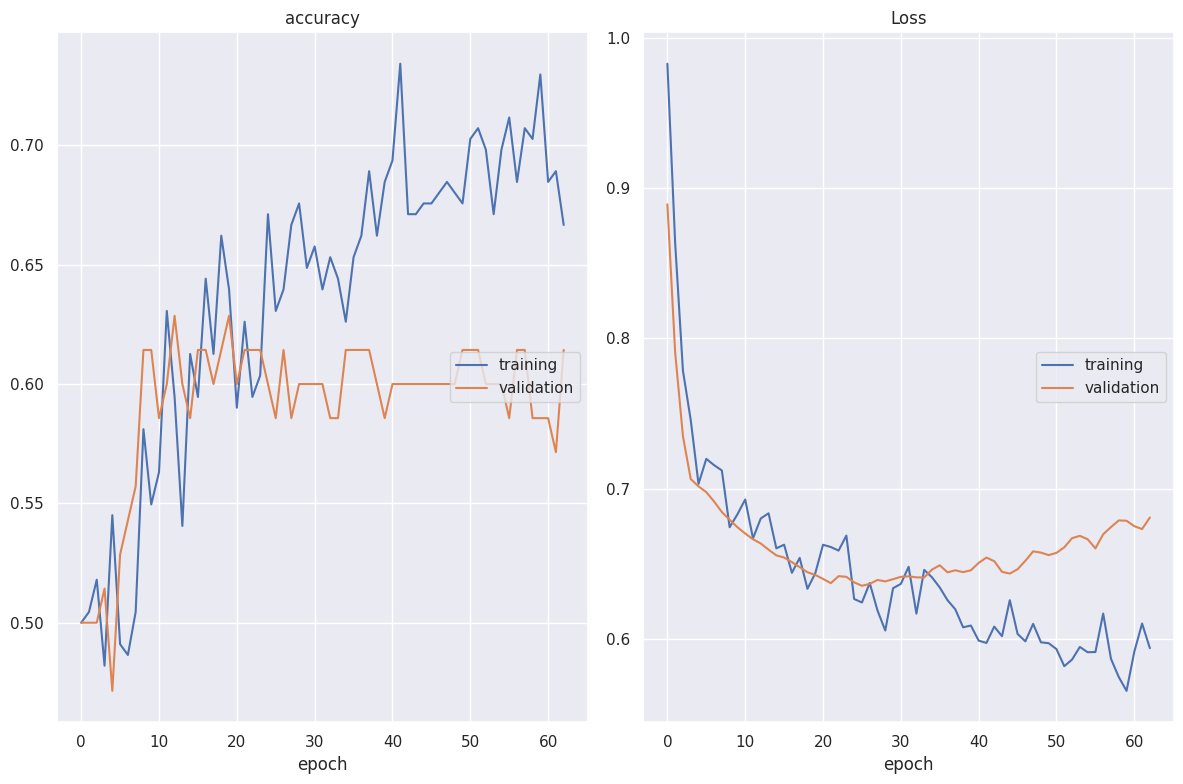

accuracy
	training         	 (min:    0.482, max:    0.734, cur:    0.667)
	validation       	 (min:    0.471, max:    0.629, cur:    0.614)
Loss
	training         	 (min:    0.565, max:    0.983, cur:    0.594)
	validation       	 (min:    0.635, max:    0.889, cur:    0.681)

Epoch 63: val_accuracy did not improve from 0.62857
5/5 [==============================] - 1s 141ms/step - loss: 0.5937 - accuracy: 0.6667 - val_loss: 0.6807 - val_accuracy: 0.6143


In [163]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_50'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=300)

#### Prediction and results

Accuracy: 0.6351351351351351
Precision: [0.63888889 0.63157895]
Recall: 0.6486486486486487
F1 score: 0.640000
ROC AUC: 0.635135


(0.6351351351351351,
 array([0.63888889, 0.63157895]),
 0.6486486486486487,
 0.64,
 0.6351351351351352)

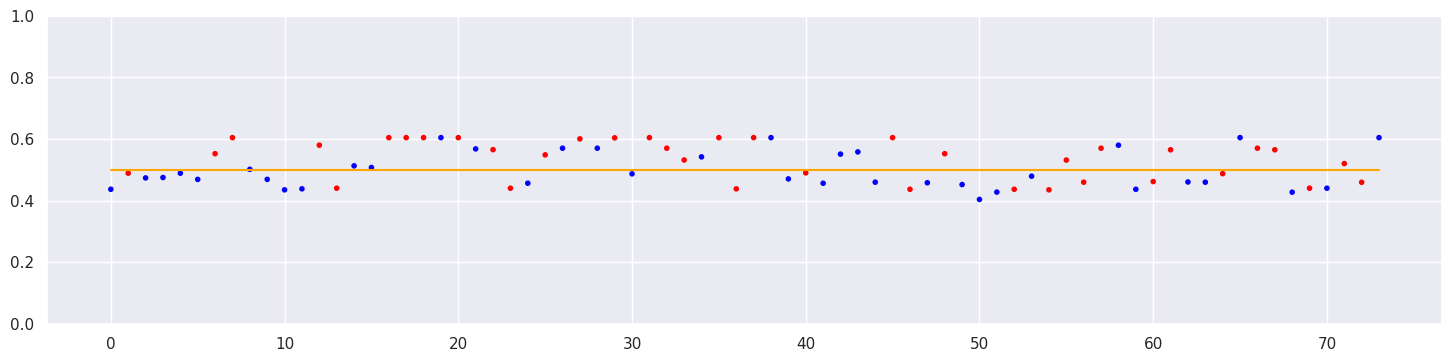

<Figure size 640x480 with 0 Axes>

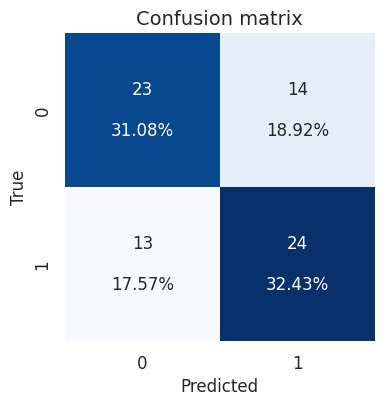

In [164]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=300

#### Create and train model

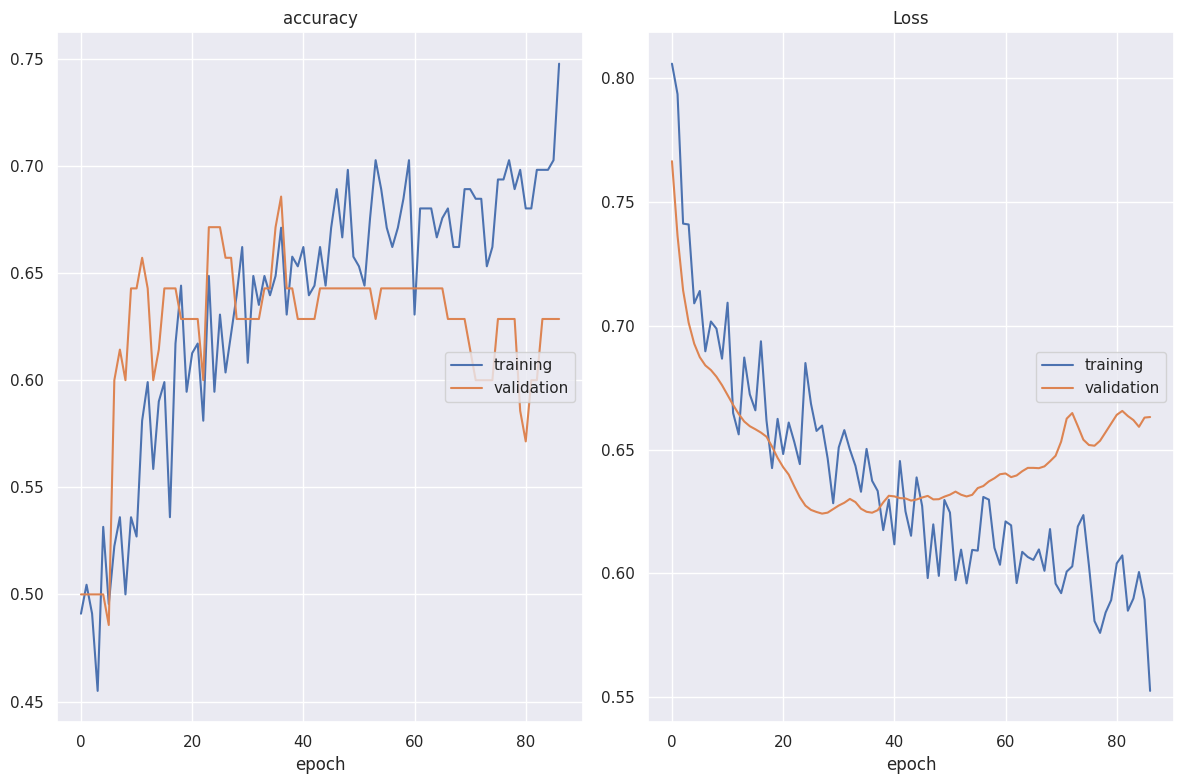

accuracy
	training         	 (min:    0.455, max:    0.748, cur:    0.748)
	validation       	 (min:    0.486, max:    0.686, cur:    0.629)
Loss
	training         	 (min:    0.553, max:    0.806, cur:    0.553)
	validation       	 (min:    0.624, max:    0.767, cur:    0.663)

Epoch 87: val_accuracy did not improve from 0.68571
3/3 [==============================] - 1s 260ms/step - loss: 0.5525 - accuracy: 0.7477 - val_loss: 0.6632 - val_accuracy: 0.6286


In [165]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_100'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.6081081081081081
Precision: [0.625     0.5952381]
Recall: 0.6756756756756757
F1 score: 0.632911
ROC AUC: 0.608108


(0.6081081081081081,
 array([0.625    , 0.5952381]),
 0.6756756756756757,
 0.6329113924050633,
 0.6081081081081081)

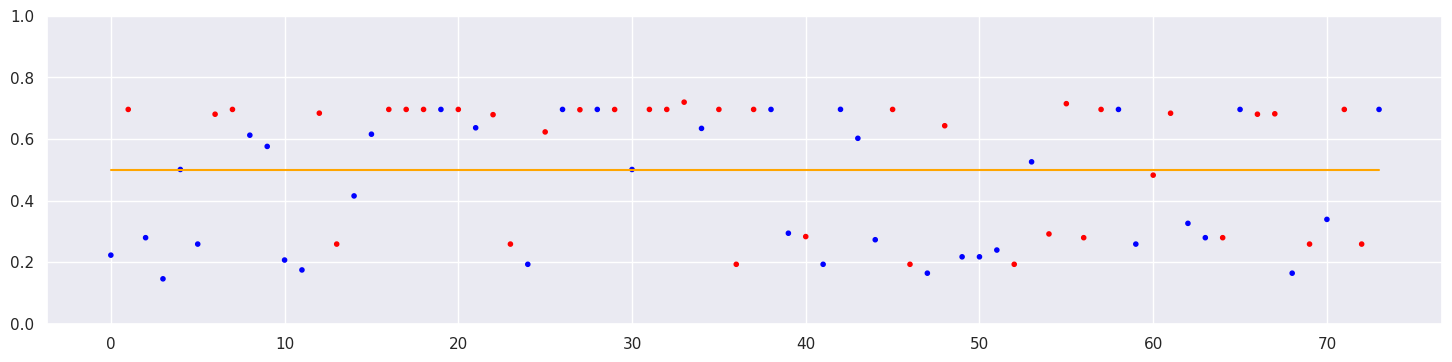

<Figure size 640x480 with 0 Axes>

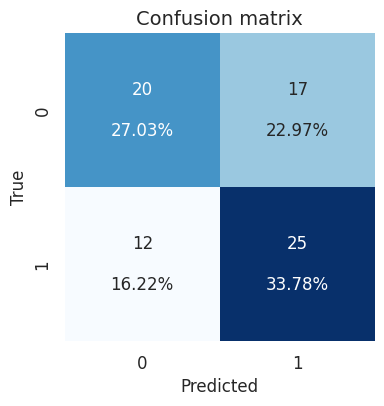

In [166]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=300

#### Create and train model

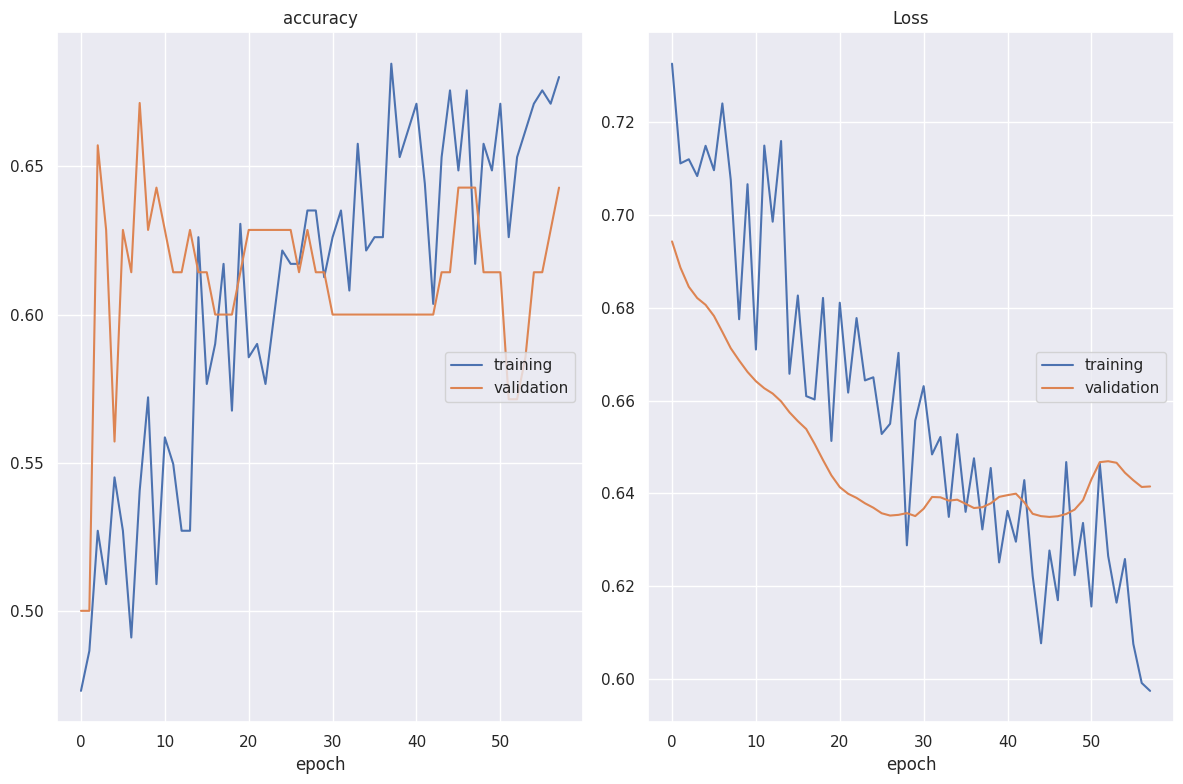

accuracy
	training         	 (min:    0.473, max:    0.685, cur:    0.680)
	validation       	 (min:    0.500, max:    0.671, cur:    0.643)
Loss
	training         	 (min:    0.597, max:    0.733, cur:    0.597)
	validation       	 (min:    0.635, max:    0.694, cur:    0.642)

Epoch 58: val_accuracy did not improve from 0.67143
2/2 [==============================] - 1s 549ms/step - loss: 0.5975 - accuracy: 0.6802 - val_loss: 0.6415 - val_accuracy: 0.6429


In [167]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_150'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.5540540540540541
Precision: [0.57692308 0.54166667]
Recall: 0.7027027027027027
F1 score: 0.611765
ROC AUC: 0.554054


(0.5540540540540541,
 array([0.57692308, 0.54166667]),
 0.7027027027027027,
 0.611764705882353,
 0.5540540540540541)

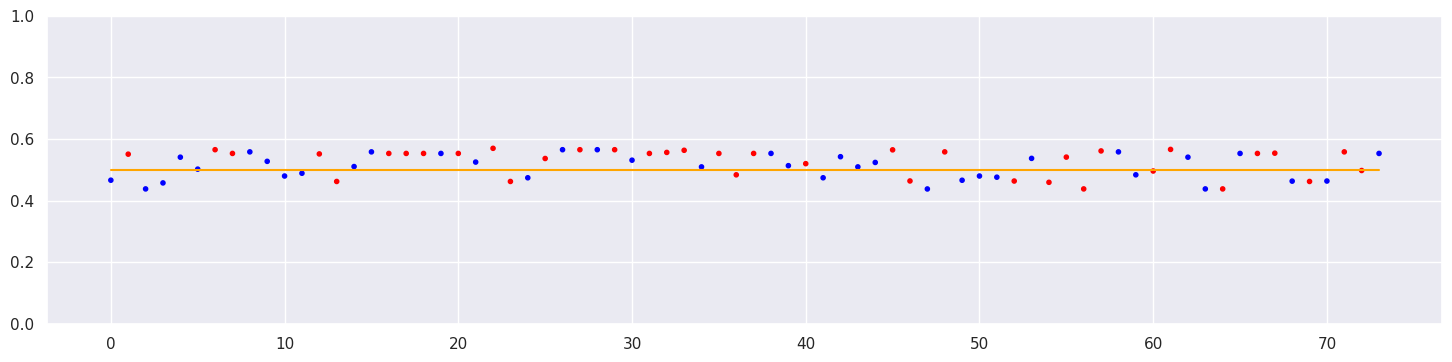

<Figure size 640x480 with 0 Axes>

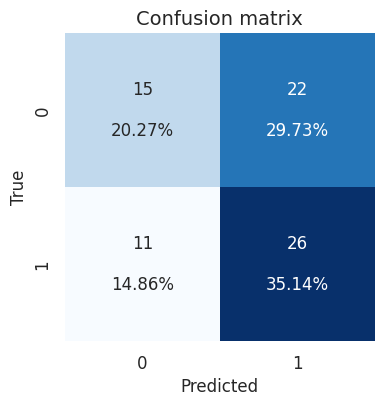

In [168]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=300

#### Create and train model

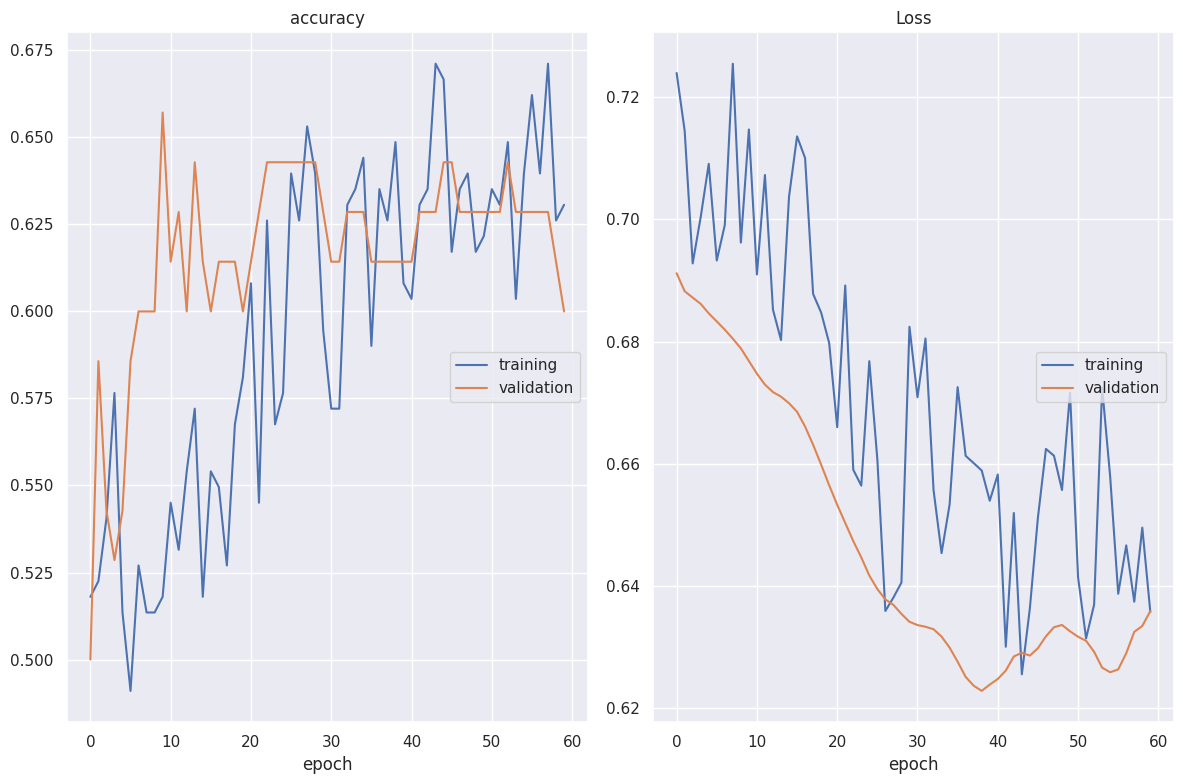

accuracy
	training         	 (min:    0.491, max:    0.671, cur:    0.631)
	validation       	 (min:    0.500, max:    0.657, cur:    0.600)
Loss
	training         	 (min:    0.626, max:    0.725, cur:    0.636)
	validation       	 (min:    0.623, max:    0.691, cur:    0.636)

Epoch 60: val_accuracy did not improve from 0.65714
2/2 [==============================] - 1s 569ms/step - loss: 0.6358 - accuracy: 0.6306 - val_loss: 0.6359 - val_accuracy: 0.6000


In [169]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.5945945945945946
Precision: [0.62962963 0.57446809]
Recall: 0.7297297297297297
F1 score: 0.642857
ROC AUC: 0.594595


(0.5945945945945946,
 array([0.62962963, 0.57446809]),
 0.7297297297297297,
 0.6428571428571429,
 0.5945945945945945)

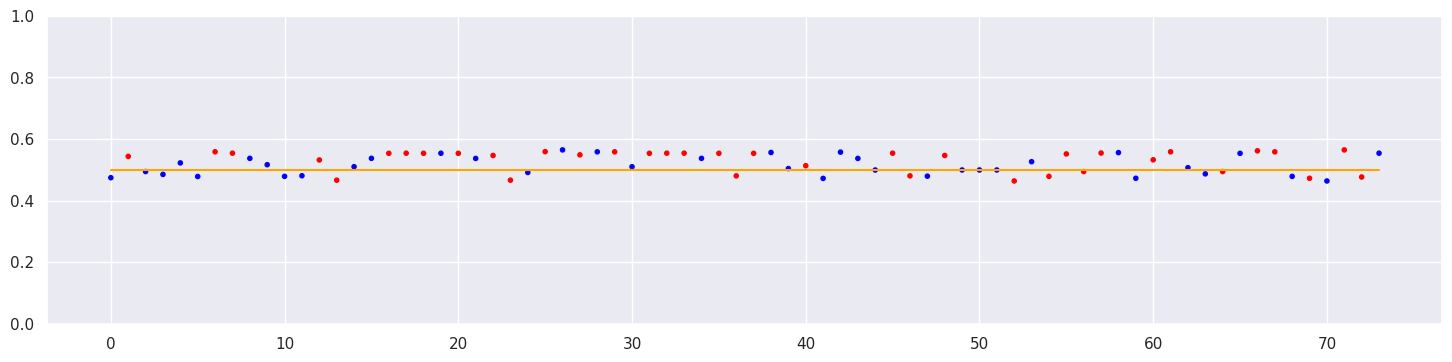

<Figure size 640x480 with 0 Axes>

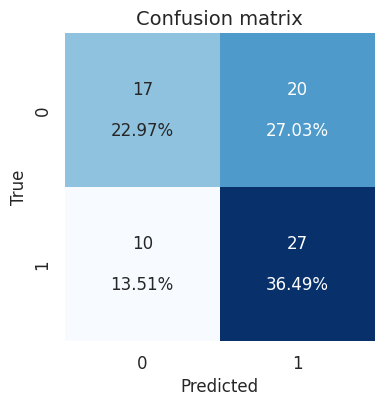

In [170]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=300

#### Create and train model

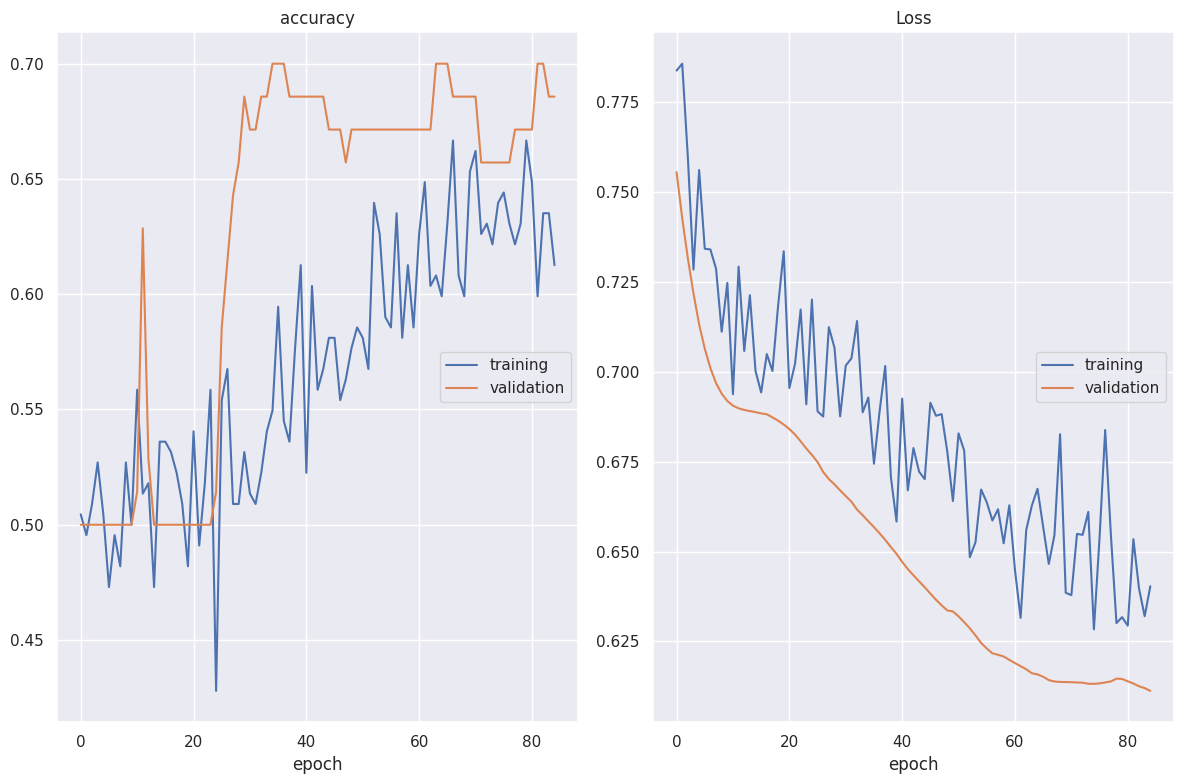

accuracy
	training         	 (min:    0.428, max:    0.667, cur:    0.613)
	validation       	 (min:    0.500, max:    0.700, cur:    0.686)
Loss
	training         	 (min:    0.628, max:    0.786, cur:    0.640)
	validation       	 (min:    0.611, max:    0.756, cur:    0.611)

Epoch 85: val_accuracy did not improve from 0.70000
1/1 [==============================] - 1s 542ms/step - loss: 0.6403 - accuracy: 0.6126 - val_loss: 0.6112 - val_accuracy: 0.6857


In [171]:
model_name = 'model_users_only_500_1_v2_wo_outliers_batch_size_250'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6216216216216216
Precision: [0.63636364 0.6097561 ]
Recall: 0.6756756756756757
F1 score: 0.641026
ROC AUC: 0.621622


(0.6216216216216216,
 array([0.63636364, 0.6097561 ]),
 0.6756756756756757,
 0.6410256410256411,
 0.6216216216216216)

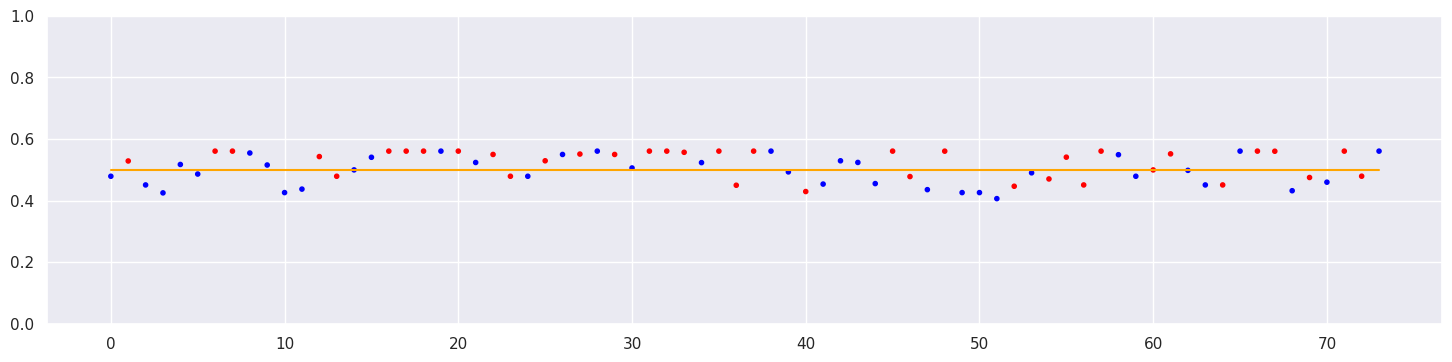

<Figure size 640x480 with 0 Axes>

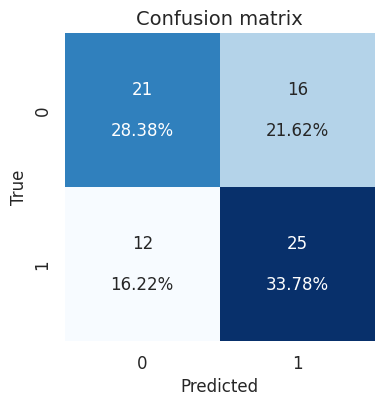

In [172]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)